In [431]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle
import seaborn as sns

# "Deterministic" single target [Complete]
Load and plot RL training curves

In [351]:
data_det = pd.read_csv('../data/tabular-active-search-k1-det/tabular_active_search_k1_det_2020_11_12_00_31_19_0000--s-0/progress.csv')

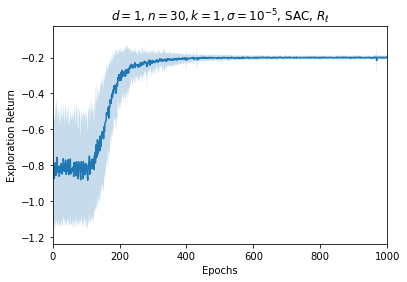

In [568]:
data = data_det
_ = plt.fill_between(data['Epoch'],data['exploration/Returns Mean'] - data['exploration/Returns Std'] , data['exploration/Returns Mean'] + data['exploration/Returns Std'],alpha=0.25)
_ = plt.plot(data['exploration/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-5}$, SAC, $R_\ell$')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Exploration Return')
_ = plt.xlim([0,1000])
plt.savefig('RL_curve_k1_det_expl.pdf')

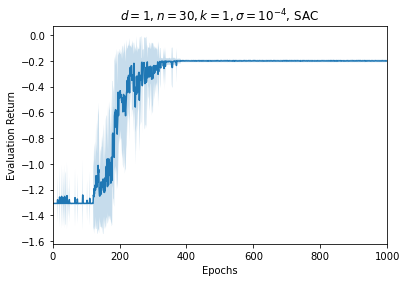

In [353]:
data = data_det
_ = plt.fill_between(data['Epoch'],data['evaluation/Returns Mean'] - data['evaluation/Returns Std'] , data['evaluation/Returns Mean'] + data['evaluation/Returns Std'],alpha=0.25)
_ = plt.plot(data['evaluation/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-5}$, SAC')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Evaluation Return')
_ = plt.xlim([0,1000])
plt.savefig('RL_curve_k1_det_eval.pdf')

Load, generate and plot full-recovery results

In [354]:
entropy_results_det_short = pickle.load(open('/Users/conor/Documents/PHD_RESEARCH/ACTIVE_SEARCH_AS_RL/rlkit/scripts/entropy_results_det_short.p', "rb" ))
recovery_results_det_short = pickle.load(open('/Users/conor/Documents/PHD_RESEARCH/ACTIVE_SEARCH_AS_RL/rlkit/scripts/recovery_results_det_short.p', "rb" ))

In [355]:
def split(x):
    x1 = np.zeros(len(x))
    x2 = np.zeros(len(x))
    length = np.sum(np.asarray(x) > 0)
    counter = 0
    if length == 1:
        return x, x
    if length == 0:
        raise Exception('Invalid split input vector!')
    for i in range(len(x)):
        if counter < int(length/2):
            x1[i] = x[i]
        else:
            x2[i] = x[i]
        counter += x[i]
    return x1,x2

In [453]:
class Belief():
    def __init__(self,n=1,sigma=.1,eta=2,num_representation_draws=100, lmbd=1, itr=100,k=1):
        self.X = []
        self.y = []
        self.n = n
        self.sigma = sigma
        self.eta = eta
        self.num_representation_draws = num_representation_draws
        self.lmbd = lmbd
        self.itr = itr
        self.k = k

        sparse_vecs = set()

        if self.k == 1:
            for i in range(self.n):
                sparse_vec = np.zeros(self.n)
                sparse_vec[i] = 1
                sparse_vecs.add(tuple(sparse_vec))
        elif self.k == 2:
            for i in range(self.n):
                for j in range(self.n):                
                    sparse_vec = np.zeros(self.n)
                    sparse_vec[i] = 1
                    sparse_vec[j] = 1                    
                    sparse_vecs.add(tuple(sparse_vec))            

        self.sparse_vecs = np.asarray(list(sparse_vecs))
        self.prior = np.ones(len(self.sparse_vecs))/len(self.sparse_vecs)
    
    def filt(self,x,y):
        self.X.append(x)
        self.y.append(y)
        prior = self.prior
        posterior = np.zeros(len(self.sparse_vecs))
        for j in range(len(posterior)):
            posterior[j] =  self.gauss_pdf( y - self.sparse_vecs[j].T @ x )*prior[j]
        posterior = posterior/np.sum(posterior)
        self.prior = posterior

    def gauss_pdf(self,x):
        return np.exp(-0.5*((x/self.sigma)**2))
    

    def true_reward(self,beta):
        expectation = 0
        for index, sparse_vec in enumerate(self.sparse_vecs):
            expectation += self.prior[index] * np.mean((sparse_vec - beta)**2)
        return -1*expectation

    def sample(self):
        return self.sparse_vecs[np.random.choice(np.arange(len(self.sparse_vecs)), p=self.prior )]          
    
    def representation(self):
        return self.prior
    
    def entropy(self):
        return scipy.stats.entropy(self.prior)

In [342]:
n= 30
T = 30
sparse_vecs = set()
NUM_TRIALS = 1000
GAMMA = 0.99
sigma=.00001

bel = Belief(n,sigma=sigma)

returns = []
recoveries_det = np.zeros((NUM_TRIALS,2*T))

for i in range(n):
    sparse_vec = np.zeros(n)
    sparse_vec[i] = 1
    sparse_vecs.add(tuple(sparse_vec))

sparse_vecs = np.asarray(list(sparse_vecs))

for trial in range(NUM_TRIALS):
    print(trial)
    bel = Belief(n,sigma=sigma)    
    beta = bel.sample()
    prev = np.ones(n)
    ep_return = 0
    for i in beta:
        if i == 0:
            print('.', end="")
        else:
            print('*', end="")
    print('\n')
            
    for t in range(2*T):
        x1, x2 = split(prev)

        y1 = (x1/np.sum(x1)) @ beta + (np.random.normal()*sigma)
        bel.filt(x1/np.sum(x1),y1)
        reward1 = bel.true_reward(beta)
        
        recovery = int(np.all(bel.sparse_vecs[np.argmax(bel.prior)] == beta))
        recoveries_det[trial][t] = recovery
        
        print('\r', end='')
        for i in x1:
            if i == 0:
                print('.', end="")
            else:
                print(1, end="")
        print(recovery1, '\r')        
        
        if y1 > 3*sigma:
            prev = x1            
        else:
            prev = x2

0
*.............................

111111111111111...............1 
1111111.......................1 
111...........................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1........

.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
..........

............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
9
....................*.........

111111111111111...............1 
...............1111111........1 
...............111............1 
..................11..........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
.........

...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
..........

........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.

.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
22
...........*..................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
.....1........................1 
......1.

.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1

...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
..........

.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
35
..........................*...

111111111111111...............1 
...............1111111........1 
......................1111....1 
..........................11..1 
........

.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
39
.............................*

111111111111111...............1 
...............1111111........1 
......................1111....1 
..........................11..1 
............................1.1 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
........

1111111.......................1 
111...........................1 
...11.........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1......

......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
..........

.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1

..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
56
.................*............

111111111111111...............1 
...............1111111........1 
...............111............1 
...............1..............1 
................1.............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
........

............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
..........

...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
..........

.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
69
.................*............

111111111111111...............1 
...............1111111........1 
...............111............1 
...............1..............1 
................1.............1 
........

........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
..........

...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
..........

....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
82
.............*................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
........

....1.........................1 
....1.........................1 
86
............*.................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
...........1..................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
........

.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
..........

1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
95
..*...........................

111111111111111...............1 
1111111.......................1 
111...........................1 
1.............................1 
.1............................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1.....

..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..........

.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1........

..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
108
............*.................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
...........1..................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
.......

....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
..........

.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1........

................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
121
.........*....................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
.......11.....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.......

......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1...

................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
..........

.............................11 
.............................11 
.............................11 
.............................11 
134
..*...........................

111111111111111...............1 
1111111.......................1 
111...........................1 
1.............................1 
.1............................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1....

...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
..........

............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
143
......

...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
147
...............*..............

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
.............1................1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
.......

....1.........................1 
151
...............*..............

111111111111111...............1 
...............1111111........1 
...............111............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
.......

111...........................1 
1.............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1........

.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
160
......

..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
164
..................*...........

111111111111111...............1 
...............1111111........1 
...............111............1 
..................11..........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
.......

...........1..................1 
...........1..................1 
...........1..................1 
168
...................*..........

111111111111111...............1 
...............1111111........1 
...............111............1 
..................11..........1 
..................1...........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
.......

...11.........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1......

........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
..........

........1.....................1 
........1.....................1 
........1.....................1 
181
............*.................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
...........1..................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
.......

........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
..........

........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
190
............................*.

111111111111111...............1 
...............1111111........1 
......................1111....1 
.......

.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1

..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
199
......

..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
203
............................*.

111111111111111...............1 
...............1111111........1 
......................1111....1 
..........................11..1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
.......

.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1........

1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
212
................*.............

111111111111111...............1 
...............1111111........1 
...............111............1 
...............1..............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
.......

........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
216
......................*.......

111111111111111...............1 
...............1111111........1 
......................1111....1 
......................11......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
.......

...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
..........

.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1

..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
229
........................*.....

111111111111111...............1 
...............1111111........1 
.......

..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
233
..........................*...

111111111111111...............1 
...............1111111........1 
......................1111....1 
..........................11..1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
.......

............................1.1 
237
.....*........................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1.

................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
..........

........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.

.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
250
..........*...................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
.......11.....................1 
.........1....................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
.......

.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
254
...................*..........

111111111111111...............1 
...............1111111........1 
...............111............1 
..................11..........1 
..................1...........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
.......

111111111111111...............1 
...............1111111........1 
......................1111....1 
......................11......1 
........................1.....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
..........

...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
..........

............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
267
.................*............

111111111111111...............1 
...............1111111........1 
...............111............1 
...............1..............1 
.......

..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
271
*.............................

111111111111111...............1 
1111111.......................1 
111...........................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1......

........................1.....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
..........

......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
..........

1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
284
.*............................

111111111111111...............1 
1111111.......................1 
111...........................1 
1.............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1.....

..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........

..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........

...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
297
....*.........................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11..

...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
301
*.............................

111111111111111...............1 
1111111.......................1 
111...........................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1......

.......11.....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1

.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1........

.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
314
......................*.......

111111111111111...............1 
...............1111111........1 
......................1111....1 
......................11......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
.......

............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
318
...................*..........

111111111111111...............1 
...............1111111........1 
...............111............1 
..................11..........1 
..................1...........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
.......

................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
..........

........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.

......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
331
.........................*....

111111111111111...............1 
...............1111111........1 
......................1111....1 
......................11......1 
........................1.....1 
.........................1....1 
.........................1....1 
.........................1....1 
.......

..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1.......

...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
..........

..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
344
.......................*......

111111111111111...............1 
...............1111111........1 
.......

.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
348
.............*................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.......

352
....................*.........

111111111111111...............1 
...............1111111........1 
...............111............1 
..................11..........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
.......

.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
..........

.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
361
.....................*........

111111111111111...............1 
...............1111111........1 
...............111............1 
..................11..........1 
....................1.........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.......

...............1111111........1 
......................1111....1 
..........................11..1 
..........................1...1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
..........

................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
..........

.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
374
..........*...................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
.......11.....................1 
.........1....................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
.......

................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
..........

.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1....

......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
387
.........*....................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
.......11.....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.......

......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
..........

..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........

............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
..........

...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
404
.*............................

111111111111111...............1 
1111111.......................1 
111...........................1 
1.............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1.....

1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.........

.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
413
.....*........................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1.

................1.............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
..........

............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
..........

.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
426
...........*..................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
.......

......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
..........

..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........

.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
439
...*..........................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1...

..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1.......

.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
..........

...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
452
............................*.

111111111111111...............1 
...............1111111........1 
......................1111....1 
..........................11..1 
............................1.1 
.......

..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
456
........................*.....

111111111111111...............1 
...............1111111........1 
......................1111....1 
......................11......1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
.......

....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
460
...........*..................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
.....1........................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1

.............................*

111111111111111...............1 
...............1111111........1 
......................1111....1 
..........................11..1 
............................1.1 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
...........

.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1....

..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
473
................*.............

111111111111111...............1 
...............1111111........1 
...............111............1 
...............1..............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
.......

111111111111111...............1 
1111111.......................1 
111...........................1 
1.............................1 
.1............................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1.......

...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
..........

...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
486
....................*.........

111111111111111...............1 
...............1111111........1 
...............111............1 
..................11..........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
.......

......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
..........

............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
495
*.............................

111111111111111...............1 
1111111.......................1 
111...........................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1......

..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........

...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
..........

........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
..........

..................1...........1 
..................1...........1 
512
.............................*

111111111111111...............1 
...............1111111........1 
......................1111....1 
..........................11..1 
............................1.1 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.......

................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
..........

..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
521
.........................*....

111111111111111...............1 
...............1111111........1 
......................1111....1 
......................11......1 
........................1.....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.......

.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1........

............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
530
.............*................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.......

......................11......1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
..........

.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1....

............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
543
......

...............1111111........1 
......................1111....1 
......................11......1 
........................1.....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
..........

...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
..........

....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
556
..*...........................

111111111111111...............1 
1111111.......................1 
111...........................1 
1.............................1 
.1............................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1....

......................11......1 
......................1.......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
..........

1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.........

1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
569
...*..........................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
...1...

..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
573
.......*......................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
.......11.....................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......

111111111111111...............1 
...............1111111........1 
......................1111....1 
..........................11..1 
............................1.1 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
..........

.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
..........

.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
586
.......................*......

111111111111111...............1 
...............1111111........1 
.......

...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
590
....*.........................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
...1..........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1..

..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1.......

.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
599
............*.................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
...........1..................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
.......

111...........................1 
...11.........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1......

.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
..........

................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
612
...........*..................

111111111111111...............1 
1111111.......................1 
.......

1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
616
.*............................

111111111111111...............1 
1111111.......................1 
111...........................1 
1.............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1.....

.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
..........

..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..........

...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
629
........................*.....

111111111111111...............1 
...............1111111........1 
......................1111....1 
......................11......1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
.......

.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1..

....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
..........

.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
642
.......*......................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
.......

.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
646
................*.............

111111111111111...............1 
...............1111111........1 
...............111............1 
...............1..............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
.......

......................1.......1 
650
...*..........................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1...

......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
..........

......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
659
...............*..............

111111111111111...............1 
...............1111111........1 
...............111............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
.......

1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
663
..............*...............

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
.............1................1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
.......

...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
..........

....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
672
......

........................1.....1 
676
.......................*......

111111111111111...............1 
...............1111111........1 
......................1111....1 
......................11......1 
......................1.......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......

..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........

...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
..........

.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
689
..............*...............

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
.............1................1 
.......

.......1......................1 
.......1......................1 
693
......*.......................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
.....1........................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1

..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
698
...............*..............

111111111111111...............1 
...............1111111........1 
...............111............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
.......

......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
702
.....*........................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1.

..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..........

1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
711
............*.................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
...........1..................1 
............1.................1 
.......

..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1.......

......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
720
.......*......................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
.......11.....................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......

.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
..........

....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
..........

..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
733
...............*..............

1111111

.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
737
...*..........................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1...

..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
741
.....*........................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1.

........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.

..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
750
..........*...................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
.......11.....................1 
.........1....................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
.......

....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.....

..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........1...................1 
..........

..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
763
........*.....................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
.......

...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
767
.....*........................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1.

111111111111111...............1 
...............1111111........1 
...............111............1 
...............1..............1 
................1.............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
..........

.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
..........

......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
780
.....*........................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1.

.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1........

.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1............................1 
.1........

.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1..

..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
797
............*.................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
...........1..................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
.......

.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
..........

...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
...........................1..1 
806
.............*................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.............1................1 
.......

................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
................1.............1 
..........

.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
815
..........................*...

111111111111111...............1 
...............1111111........1 
......................1111....1 
..........................11..1 
..........................1...1 
.......

.........................1....1 
.........................1....1 
.........................1....1 
819
...............*..............

111111111111111...............1 
...............1111111........1 
...............111............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
.......

111111111111111...............1 
...............1111111........1 
...............111............1 
..................11..........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..................1...........1 
..........

............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
..........

.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
832
....*.........................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
...1..........................1 
....1.........................1 
....1..

............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
836
............................*.

111111111111111...............1 
...............1111111........1 
......................1111....1 
..........................11..1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
.......

..........................11..1 
............................1.1 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
..........

......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
..........

....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
849
......

.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
853
........*.....................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
.......11.....................1 
.......1......................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
.......

...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
...................1..........1 
..........

.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.........1....................1 
862
*.............................

111111111111111...............1 
1111111.......................1 
111...........................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1......

............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
866
............*.................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
...........1..................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
............1.................1 
.......

...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1......

............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
............................1.1 
875
..................*...........

111111111111111...............1 
...............1111111........1 
...............111............1 
..................11..........1 
..................1...........1 
..................1...........1 
..................1...........1 
.......

...1..........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.....

...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
...1..........................1 
884
.........................*....

1111111

.....*........................

111111111111111...............1 
1111111.......................1 
111...........................1 
...11.........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1........................1 
.....1.....

..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........

......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
......................1.......1 
897
.........*....................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
.......11.....................1 
.........1....................1 
.........1....................1 
.........1....................1 
.......

.1............................1 
.1............................1 
.1............................1 
901
........*.....................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
.......11.....................1 
.......1......................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
.......

1111111.......................1 
111...........................1 
1.............................1 
.1............................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1.......

....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
....................1.........1 
..........

..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1.......

....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
918
.......................*......

111111111111111...............1 
...............1111111........1 
......................1111....1 
......................11......1 
......................1.......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......

........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
922
.............................*

111111111111111...............1 
...............1111111........1 
......................1111....1 
..........................11..1 
............................1.1 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.......

.......*......................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
.......11.....................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1...

..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1...........................1 
..1.......

...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
...........1..................1 
935
...........*..................

1111111

........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
........1.....................1 
939
........................*.....

111111111111111...............1 
...............1111111........1 
......................1111....1 
......................11......1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
.......

1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.............................1 
1.........

.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
..........

........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
........................1.....1 
952
..*...........................

1111111

.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
.............................11 
956
..............*...............

111111111111111...............1 
1111111.......................1 
.......1111...................1 
...........11.................1 
.............1................1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
..............1...............1 
.......

.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
..........

.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
.........................1....1 
965
*.............................

111111111111111...............1 
1111111.......................1 
111...........................1 
1.............................1 
1.............................1 
1.............................1 
1......

.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
.......................1......1 
969
..........................*...

111111111111111...............1 
...............1111111........1 
......................1111....1 
..........................11..1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
..........................1...1 
.......

....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
....1.........................1 
973
.......*......................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
.......11.....................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......

...............1111111........1 
...............111............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
...............1..............1 
..........

.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
.................1............1 
..........

......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
......1.......................1 
986
.......*......................

111111111111111...............1 
1111111.......................1 
.......1111...................1 
.......11.....................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......

.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1..

.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1......................1 
.......1..

.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
.....................1........1 
..........

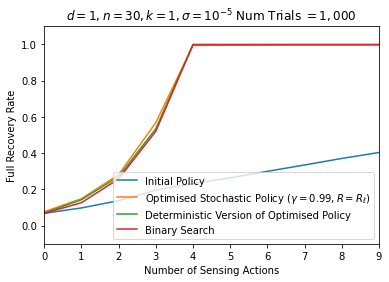

In [563]:
NUM_OBSERVATIONS = 10
NUM_TRIALS = 1000

sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_short[:,0,:]).flatten(),ci='sd',label='Initial Policy',err_kws={'alpha':0})
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_short[:,1,:]).flatten(),ci='sd',label='Single Cell Random')
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_short[:,2,:]).flatten(),ci='sd',label='Optimised Stochastic Policy $(\gamma=0.99,R=R_\ell)$',err_kws={'alpha':0})
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_short[:,3,:]).flatten(),ci='sd',label='Deterministic Version of Optimised Policy',err_kws={'alpha':0})
sns.lineplot(x=list(range(60))*NUM_TRIALS,y=np.asarray(recoveries_det[:,:]).flatten(),ci='sd',label='Binary Search',err_kws={'alpha':0})
plt.xlabel('Number of Sensing Actions')
plt.ylabel('Full Recovery Rate')
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-5}$ Num Trials $= 1,000$')
plt.legend(loc='lower right')
plt.xlim([0,9])
plt.ylim([-0.1,1.1])
plt.savefig('full_recovery_k1_det.pdf')


Conclusion: RL performs just as well as baseline (which is as good as we can hope for). Now going to try noisy case.

# Low-noise single target [Ongoing]
Load and plot RL training curves.

In [358]:
data_low = pd.read_csv('../data/tabular-active-search-k1/tabular_active_search_k1_2020_11_10_16_18_25_0000--s-0/progress.csv')

In [359]:
data_continuation = pd.read_csv('../data/tabular-active-search-k1-continuation-many-epochs/tabular_active_search_k1_continuation_many_epochs_2020_11_11_15_30_52_0000--s-0/progress.csv')

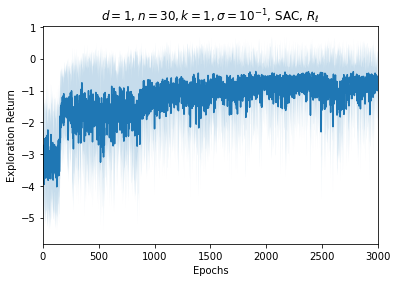

In [570]:
data = data_low
_ = plt.fill_between(data['Epoch'],data['exploration/Returns Mean'] - data['exploration/Returns Std'] , data['exploration/Returns Mean'] + data['exploration/Returns Std'],alpha=0.25)
_ = plt.plot(data['exploration/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$, SAC, $R_\ell$')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Exploration Return')
_ = plt.xlim([0,3000])
plt.savefig('RL_curve_k1_low_expl.pdf')

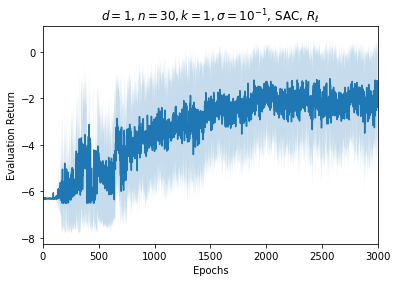

In [572]:
data = data_low
_ = plt.fill_between(data['Epoch'],data['evaluation/Returns Mean'] - data['evaluation/Returns Std'] , data['evaluation/Returns Mean'] + data['evaluation/Returns Std'],alpha=0.25)
_ = plt.plot(data['evaluation/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$, SAC, $R_\ell$')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Evaluation Return')
_ = plt.xlim([0,3000])
plt.savefig('RL_curve_k1_low_eval.pdf')

Load, generate and plot full-recovery results

In [385]:
entropy_results_low = pickle.load(open('/Users/conor/Documents/PHD_RESEARCH/ACTIVE_SEARCH_AS_RL/rlkit/scripts/entropy_results_low_cont.p', "rb" ))
recovery_results_low = pickle.load(open('/Users/conor/Documents/PHD_RESEARCH/ACTIVE_SEARCH_AS_RL/rlkit/scripts/recovery_results_low_cont.p', "rb" ))

In [508]:
n= 30
T = 100
sparse_vecs = set()
NUM_TRIALS = 1000
NUM_MONTE_CARLO_SAMPLES = 1
sigma=.1

bel = Belief(n,sigma=sigma)

recoveries_low_k1 = np.zeros((NUM_TRIALS,T))

sensing_actions = set()

for i in range(n):
    sparse_vec = np.zeros(n)
    sparse_vec[i] = 1
    sparse_vecs.add(tuple(sparse_vec))

for i in range(n):
    for j in range(n):
        x = np.zeros(n)
        start = i
        length = min( max(j,1), n-i)
        interval = np.ones(length) / length
        x[start:start+length] = interval
        sensing_actions.add(tuple(x))

sparse_vecs = np.asarray(list(sparse_vecs))
sensing_actions = np.asarray(list(sensing_actions))

for trial in range(NUM_TRIALS):
    bel = Belief(n,sigma=sigma)    
    beta = bel.sample()
            
    for t in range(T):
        print(trial,t)
        best = np.inf
        for sensing_action in sensing_actions:
            av_entropy = 0
            for m in range(NUM_MONTE_CARLO_SAMPLES):
                beta_tilde = bel.sample()
                bel_tilde = copy.deepcopy(bel)
                y_tilde = sensing_action @ beta_tilde + (np.random.normal()*sigma)
                bel_tilde.filt(sensing_action,y_tilde)
                av_entropy += bel_tilde.entropy() / NUM_MONTE_CARLO_SAMPLES
                
            if av_entropy < best:
                best = av_entropy
                x = sensing_action

        y = x @ beta + (np.random.normal()*sigma)
        bel.filt(x,y)
        
        recovery = int(np.all(bel.sparse_vecs[np.argmax(bel.prior)] == beta))
        recoveries_low_k1[trial][t] = recovery

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
2 0
2 1
2 2
2 3
2 4


15 59
15 60
15 61
15 62
15 63
15 64
15 65
15 66
15 67
15 68
15 69
15 70
15 71
15 72
15 73
15 74
15 75
15 76
15 77
15 78
15 79
15 80
15 81
15 82
15 83
15 84
15 85
15 86
15 87
15 88
15 89
15 90
15 91
15 92
15 93
15 94
15 95
15 96
15 97
15 98
15 99
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
16 11
16 12
16 13
16 14
16 15
16 16
16 17
16 18
16 19
16 20
16 21
16 22
16 23
16 24
16 25
16 26
16 27
16 28
16 29
16 30
16 31
16 32
16 33
16 34
16 35
16 36
16 37
16 38
16 39
16 40
16 41
16 42
16 43
16 44
16 45
16 46
16 47
16 48
16 49
16 50
16 51
16 52
16 53
16 54
16 55
16 56
16 57
16 58
16 59
16 60
16 61
16 62
16 63
16 64
16 65
16 66
16 67
16 68
16 69
16 70
16 71
16 72
16 73
16 74
16 75
16 76
16 77
16 78
16 79
16 80
16 81
16 82
16 83
16 84
16 85
16 86
16 87
16 88
16 89
16 90
16 91
16 92
16 93
16 94
16 95
16 96
16 97
16 98
16 99
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
17 11
17 12
17 13
17 14
17 15
17 16
17 17
17 18
17 19
17 20
17 21
17 22
17 23
17 24
17 25
17 26
17 27
17 28


29 48
29 49
29 50
29 51
29 52
29 53
29 54
29 55
29 56
29 57
29 58
29 59
29 60
29 61
29 62
29 63
29 64
29 65
29 66
29 67
29 68
29 69
29 70
29 71
29 72
29 73
29 74
29 75
29 76
29 77
29 78
29 79
29 80
29 81
29 82
29 83
29 84
29 85
29 86
29 87
29 88
29 89
29 90
29 91
29 92
29 93
29 94
29 95
29 96
29 97
29 98
29 99
30 0
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24
30 25
30 26
30 27
30 28
30 29
30 30
30 31
30 32
30 33
30 34
30 35
30 36
30 37
30 38
30 39
30 40
30 41
30 42
30 43
30 44
30 45
30 46
30 47
30 48
30 49
30 50
30 51
30 52
30 53
30 54
30 55
30 56
30 57
30 58
30 59
30 60
30 61
30 62
30 63
30 64
30 65
30 66
30 67
30 68
30 69
30 70
30 71
30 72
30 73
30 74
30 75
30 76
30 77
30 78
30 79
30 80
30 81
30 82
30 83
30 84
30 85
30 86
30 87
30 88
30 89
30 90
30 91
30 92
30 93
30 94
30 95
30 96
30 97
30 98
30 99
31 0
31 1
31 2
31 3
31 4
31 5
31 6
31 7
31 8
31 9
31 10
31 11
31 12
31 13
31 14
31 15
31 16
31 17


43 37
43 38
43 39
43 40
43 41
43 42
43 43
43 44
43 45
43 46
43 47
43 48
43 49
43 50
43 51
43 52
43 53
43 54
43 55
43 56
43 57
43 58
43 59
43 60
43 61
43 62
43 63
43 64
43 65
43 66
43 67
43 68
43 69
43 70
43 71
43 72
43 73
43 74
43 75
43 76
43 77
43 78
43 79
43 80
43 81
43 82
43 83
43 84
43 85
43 86
43 87
43 88
43 89
43 90
43 91
43 92
43 93
43 94
43 95
43 96
43 97
43 98
43 99
44 0
44 1
44 2
44 3
44 4
44 5
44 6
44 7
44 8
44 9
44 10
44 11
44 12
44 13
44 14
44 15
44 16
44 17
44 18
44 19
44 20
44 21
44 22
44 23
44 24
44 25
44 26
44 27
44 28
44 29
44 30
44 31
44 32
44 33
44 34
44 35
44 36
44 37
44 38
44 39
44 40
44 41
44 42
44 43
44 44
44 45
44 46
44 47
44 48
44 49
44 50
44 51
44 52
44 53
44 54
44 55
44 56
44 57
44 58
44 59
44 60
44 61
44 62
44 63
44 64
44 65
44 66
44 67
44 68
44 69
44 70
44 71
44 72
44 73
44 74
44 75
44 76
44 77
44 78
44 79
44 80
44 81
44 82
44 83
44 84
44 85
44 86
44 87
44 88
44 89
44 90
44 91
44 92
44 93
44 94
44 95
44 96
44 97
44 98
44 99
45 0
45 1
45 2
45 3
45 4
45 5
45

57 26
57 27
57 28
57 29
57 30
57 31
57 32
57 33
57 34
57 35
57 36
57 37
57 38
57 39
57 40
57 41
57 42
57 43
57 44
57 45
57 46
57 47
57 48
57 49
57 50
57 51
57 52
57 53
57 54
57 55
57 56
57 57
57 58
57 59
57 60
57 61
57 62
57 63
57 64
57 65
57 66
57 67
57 68
57 69
57 70
57 71
57 72
57 73
57 74
57 75
57 76
57 77
57 78
57 79
57 80
57 81
57 82
57 83
57 84
57 85
57 86
57 87
57 88
57 89
57 90
57 91
57 92
57 93
57 94
57 95
57 96
57 97
57 98
57 99
58 0
58 1
58 2
58 3
58 4
58 5
58 6
58 7
58 8
58 9
58 10
58 11
58 12
58 13
58 14
58 15
58 16
58 17
58 18
58 19
58 20
58 21
58 22
58 23
58 24
58 25
58 26
58 27
58 28
58 29
58 30
58 31
58 32
58 33
58 34
58 35
58 36
58 37
58 38
58 39
58 40
58 41
58 42
58 43
58 44
58 45
58 46
58 47
58 48
58 49
58 50
58 51
58 52
58 53
58 54
58 55
58 56
58 57
58 58
58 59
58 60
58 61
58 62
58 63
58 64
58 65
58 66
58 67
58 68
58 69
58 70
58 71
58 72
58 73
58 74
58 75
58 76
58 77
58 78
58 79
58 80
58 81
58 82
58 83
58 84
58 85
58 86
58 87
58 88
58 89
58 90
58 91
58 92
58 93
58

71 15
71 16
71 17
71 18
71 19
71 20
71 21
71 22
71 23
71 24
71 25
71 26
71 27
71 28
71 29
71 30
71 31
71 32
71 33
71 34
71 35
71 36
71 37
71 38
71 39
71 40
71 41
71 42
71 43
71 44
71 45
71 46
71 47
71 48
71 49
71 50
71 51
71 52
71 53
71 54
71 55
71 56
71 57
71 58
71 59
71 60
71 61
71 62
71 63
71 64
71 65
71 66
71 67
71 68
71 69
71 70
71 71
71 72
71 73
71 74
71 75
71 76
71 77
71 78
71 79
71 80
71 81
71 82
71 83
71 84
71 85
71 86
71 87
71 88
71 89
71 90
71 91
71 92
71 93
71 94
71 95
71 96
71 97
71 98
71 99
72 0
72 1
72 2
72 3
72 4
72 5
72 6
72 7
72 8
72 9
72 10
72 11
72 12
72 13
72 14
72 15
72 16
72 17
72 18
72 19
72 20
72 21
72 22
72 23
72 24
72 25
72 26
72 27
72 28
72 29
72 30
72 31
72 32
72 33
72 34
72 35
72 36
72 37
72 38
72 39
72 40
72 41
72 42
72 43
72 44
72 45
72 46
72 47
72 48
72 49
72 50
72 51
72 52
72 53
72 54
72 55
72 56
72 57
72 58
72 59
72 60
72 61
72 62
72 63
72 64
72 65
72 66
72 67
72 68
72 69
72 70
72 71
72 72
72 73
72 74
72 75
72 76
72 77
72 78
72 79
72 80
72 81
72 82
72

85 4
85 5
85 6
85 7
85 8
85 9
85 10
85 11
85 12
85 13
85 14
85 15
85 16
85 17
85 18
85 19
85 20
85 21
85 22
85 23
85 24
85 25
85 26
85 27
85 28
85 29
85 30
85 31
85 32
85 33
85 34
85 35
85 36
85 37
85 38
85 39
85 40
85 41
85 42
85 43
85 44
85 45
85 46
85 47
85 48
85 49
85 50
85 51
85 52
85 53
85 54
85 55
85 56
85 57
85 58
85 59
85 60
85 61
85 62
85 63
85 64
85 65
85 66
85 67
85 68
85 69
85 70
85 71
85 72
85 73
85 74
85 75
85 76
85 77
85 78
85 79
85 80
85 81
85 82
85 83
85 84
85 85
85 86
85 87
85 88
85 89
85 90
85 91
85 92
85 93
85 94
85 95
85 96
85 97
85 98
85 99
86 0
86 1
86 2
86 3
86 4
86 5
86 6
86 7
86 8
86 9
86 10
86 11
86 12
86 13
86 14
86 15
86 16
86 17
86 18
86 19
86 20
86 21
86 22
86 23
86 24
86 25
86 26
86 27
86 28
86 29
86 30
86 31
86 32
86 33
86 34
86 35
86 36
86 37
86 38
86 39
86 40
86 41
86 42
86 43
86 44
86 45
86 46
86 47
86 48
86 49
86 50
86 51
86 52
86 53
86 54
86 55
86 56
86 57
86 58
86 59
86 60
86 61
86 62
86 63
86 64
86 65
86 66
86 67
86 68
86 69
86 70
86 71
86 72
86

98 93
98 94
98 95
98 96
98 97
98 98
98 99
99 0
99 1
99 2
99 3
99 4
99 5
99 6
99 7
99 8
99 9
99 10
99 11
99 12
99 13
99 14
99 15
99 16
99 17
99 18
99 19
99 20
99 21
99 22
99 23
99 24
99 25
99 26
99 27
99 28
99 29
99 30
99 31
99 32
99 33
99 34
99 35
99 36
99 37
99 38
99 39
99 40
99 41
99 42
99 43
99 44
99 45
99 46
99 47
99 48
99 49
99 50
99 51
99 52
99 53
99 54
99 55
99 56
99 57
99 58
99 59
99 60
99 61
99 62
99 63
99 64
99 65
99 66
99 67
99 68
99 69
99 70
99 71
99 72
99 73
99 74
99 75
99 76
99 77
99 78
99 79
99 80
99 81
99 82
99 83
99 84
99 85
99 86
99 87
99 88
99 89
99 90
99 91
99 92
99 93
99 94
99 95
99 96
99 97
99 98
99 99
100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
100 10
100 11
100 12
100 13
100 14
100 15
100 16
100 17
100 18
100 19
100 20
100 21
100 22
100 23
100 24
100 25
100 26
100 27
100 28
100 29
100 30
100 31
100 32
100 33
100 34
100 35
100 36
100 37
100 38
100 39
100 40
100 41
100 42
100 43
100 44
100 45
100 46
100 47
100 48
100 49
100 50
100 51
100 52
100 53


110 96
110 97
110 98
110 99
111 0
111 1
111 2
111 3
111 4
111 5
111 6
111 7
111 8
111 9
111 10
111 11
111 12
111 13
111 14
111 15
111 16
111 17
111 18
111 19
111 20
111 21
111 22
111 23
111 24
111 25
111 26
111 27
111 28
111 29
111 30
111 31
111 32
111 33
111 34
111 35
111 36
111 37
111 38
111 39
111 40
111 41
111 42
111 43
111 44
111 45
111 46
111 47
111 48
111 49
111 50
111 51
111 52
111 53
111 54
111 55
111 56
111 57
111 58
111 59
111 60
111 61
111 62
111 63
111 64
111 65
111 66
111 67
111 68
111 69
111 70
111 71
111 72
111 73
111 74
111 75
111 76
111 77
111 78
111 79
111 80
111 81
111 82
111 83
111 84
111 85
111 86
111 87
111 88
111 89
111 90
111 91
111 92
111 93
111 94
111 95
111 96
111 97
111 98
111 99
112 0
112 1
112 2
112 3
112 4
112 5
112 6
112 7
112 8
112 9
112 10
112 11
112 12
112 13
112 14
112 15
112 16
112 17
112 18
112 19
112 20
112 21
112 22
112 23
112 24
112 25
112 26
112 27
112 28
112 29
112 30
112 31
112 32
112 33
112 34
112 35
112 36
112 37
112 38
112 39
112 40
112 4

122 84
122 85
122 86
122 87
122 88
122 89
122 90
122 91
122 92
122 93
122 94
122 95
122 96
122 97
122 98
122 99
123 0
123 1
123 2
123 3
123 4
123 5
123 6
123 7
123 8
123 9
123 10
123 11
123 12
123 13
123 14
123 15
123 16
123 17
123 18
123 19
123 20
123 21
123 22
123 23
123 24
123 25
123 26
123 27
123 28
123 29
123 30
123 31
123 32
123 33
123 34
123 35
123 36
123 37
123 38
123 39
123 40
123 41
123 42
123 43
123 44
123 45
123 46
123 47
123 48
123 49
123 50
123 51
123 52
123 53
123 54
123 55
123 56
123 57
123 58
123 59
123 60
123 61
123 62
123 63
123 64
123 65
123 66
123 67
123 68
123 69
123 70
123 71
123 72
123 73
123 74
123 75
123 76
123 77
123 78
123 79
123 80
123 81
123 82
123 83
123 84
123 85
123 86
123 87
123 88
123 89
123 90
123 91
123 92
123 93
123 94
123 95
123 96
123 97
123 98
123 99
124 0
124 1
124 2
124 3
124 4
124 5
124 6
124 7
124 8
124 9
124 10
124 11
124 12
124 13
124 14
124 15
124 16
124 17
124 18
124 19
124 20
124 21
124 22
124 23
124 24
124 25
124 26
124 27
124 28
124 2

134 72
134 73
134 74
134 75
134 76
134 77
134 78
134 79
134 80
134 81
134 82
134 83
134 84
134 85
134 86
134 87
134 88
134 89
134 90
134 91
134 92
134 93
134 94
134 95
134 96
134 97
134 98
134 99
135 0
135 1
135 2
135 3
135 4
135 5
135 6
135 7
135 8
135 9
135 10
135 11
135 12
135 13
135 14
135 15
135 16
135 17
135 18
135 19
135 20
135 21
135 22
135 23
135 24
135 25
135 26
135 27
135 28
135 29
135 30
135 31
135 32
135 33
135 34
135 35
135 36
135 37
135 38
135 39
135 40
135 41
135 42
135 43
135 44
135 45
135 46
135 47
135 48
135 49
135 50
135 51
135 52
135 53
135 54
135 55
135 56
135 57
135 58
135 59
135 60
135 61
135 62
135 63
135 64
135 65
135 66
135 67
135 68
135 69
135 70
135 71
135 72
135 73
135 74
135 75
135 76
135 77
135 78
135 79
135 80
135 81
135 82
135 83
135 84
135 85
135 86
135 87
135 88
135 89
135 90
135 91
135 92
135 93
135 94
135 95
135 96
135 97
135 98
135 99
136 0
136 1
136 2
136 3
136 4
136 5
136 6
136 7
136 8
136 9
136 10
136 11
136 12
136 13
136 14
136 15
136 16
136 1

146 60
146 61
146 62
146 63
146 64
146 65
146 66
146 67
146 68
146 69
146 70
146 71
146 72
146 73
146 74
146 75
146 76
146 77
146 78
146 79
146 80
146 81
146 82
146 83
146 84
146 85
146 86
146 87
146 88
146 89
146 90
146 91
146 92
146 93
146 94
146 95
146 96
146 97
146 98
146 99
147 0
147 1
147 2
147 3
147 4
147 5
147 6
147 7
147 8
147 9
147 10
147 11
147 12
147 13
147 14
147 15
147 16
147 17
147 18
147 19
147 20
147 21
147 22
147 23
147 24
147 25
147 26
147 27
147 28
147 29
147 30
147 31
147 32
147 33
147 34
147 35
147 36
147 37
147 38
147 39
147 40
147 41
147 42
147 43
147 44
147 45
147 46
147 47
147 48
147 49
147 50
147 51
147 52
147 53
147 54
147 55
147 56
147 57
147 58
147 59
147 60
147 61
147 62
147 63
147 64
147 65
147 66
147 67
147 68
147 69
147 70
147 71
147 72
147 73
147 74
147 75
147 76
147 77
147 78
147 79
147 80
147 81
147 82
147 83
147 84
147 85
147 86
147 87
147 88
147 89
147 90
147 91
147 92
147 93
147 94
147 95
147 96
147 97
147 98
147 99
148 0
148 1
148 2
148 3
148 4


158 48
158 49
158 50
158 51
158 52
158 53
158 54
158 55
158 56
158 57
158 58
158 59
158 60
158 61
158 62
158 63
158 64
158 65
158 66
158 67
158 68
158 69
158 70
158 71
158 72
158 73
158 74
158 75
158 76
158 77
158 78
158 79
158 80
158 81
158 82
158 83
158 84
158 85
158 86
158 87
158 88
158 89
158 90
158 91
158 92
158 93
158 94
158 95
158 96
158 97
158 98
158 99
159 0
159 1
159 2
159 3
159 4
159 5
159 6
159 7
159 8
159 9
159 10
159 11
159 12
159 13
159 14
159 15
159 16
159 17
159 18
159 19
159 20
159 21
159 22
159 23
159 24
159 25
159 26
159 27
159 28
159 29
159 30
159 31
159 32
159 33
159 34
159 35
159 36
159 37
159 38
159 39
159 40
159 41
159 42
159 43
159 44
159 45
159 46
159 47
159 48
159 49
159 50
159 51
159 52
159 53
159 54
159 55
159 56
159 57
159 58
159 59
159 60
159 61
159 62
159 63
159 64
159 65
159 66
159 67
159 68
159 69
159 70
159 71
159 72
159 73
159 74
159 75
159 76
159 77
159 78
159 79
159 80
159 81
159 82
159 83
159 84
159 85
159 86
159 87
159 88
159 89
159 90
159 91
15

170 36
170 37
170 38
170 39
170 40
170 41
170 42
170 43
170 44
170 45
170 46
170 47
170 48
170 49
170 50
170 51
170 52
170 53
170 54
170 55
170 56
170 57
170 58
170 59
170 60
170 61
170 62
170 63
170 64
170 65
170 66
170 67
170 68
170 69
170 70
170 71
170 72
170 73
170 74
170 75
170 76
170 77
170 78
170 79
170 80
170 81
170 82
170 83
170 84
170 85
170 86
170 87
170 88
170 89
170 90
170 91
170 92
170 93
170 94
170 95
170 96
170 97
170 98
170 99
171 0
171 1
171 2
171 3
171 4
171 5
171 6
171 7
171 8
171 9
171 10
171 11
171 12
171 13
171 14
171 15
171 16
171 17
171 18
171 19
171 20
171 21
171 22
171 23
171 24
171 25
171 26
171 27
171 28
171 29
171 30
171 31
171 32
171 33
171 34
171 35
171 36
171 37
171 38
171 39
171 40
171 41
171 42
171 43
171 44
171 45
171 46
171 47
171 48
171 49
171 50
171 51
171 52
171 53
171 54
171 55
171 56
171 57
171 58
171 59
171 60
171 61
171 62
171 63
171 64
171 65
171 66
171 67
171 68
171 69
171 70
171 71
171 72
171 73
171 74
171 75
171 76
171 77
171 78
171 79
17

182 24
182 25
182 26
182 27
182 28
182 29
182 30
182 31
182 32
182 33
182 34
182 35
182 36
182 37
182 38
182 39
182 40
182 41
182 42
182 43
182 44
182 45
182 46
182 47
182 48
182 49
182 50
182 51
182 52
182 53
182 54
182 55
182 56
182 57
182 58
182 59
182 60
182 61
182 62
182 63
182 64
182 65
182 66
182 67
182 68
182 69
182 70
182 71
182 72
182 73
182 74
182 75
182 76
182 77
182 78
182 79
182 80
182 81
182 82
182 83
182 84
182 85
182 86
182 87
182 88
182 89
182 90
182 91
182 92
182 93
182 94
182 95
182 96
182 97
182 98
182 99
183 0
183 1
183 2
183 3
183 4
183 5
183 6
183 7
183 8
183 9
183 10
183 11
183 12
183 13
183 14
183 15
183 16
183 17
183 18
183 19
183 20
183 21
183 22
183 23
183 24
183 25
183 26
183 27
183 28
183 29
183 30
183 31
183 32
183 33
183 34
183 35
183 36
183 37
183 38
183 39
183 40
183 41
183 42
183 43
183 44
183 45
183 46
183 47
183 48
183 49
183 50
183 51
183 52
183 53
183 54
183 55
183 56
183 57
183 58
183 59
183 60
183 61
183 62
183 63
183 64
183 65
183 66
183 67
18

194 12
194 13
194 14
194 15
194 16
194 17
194 18
194 19
194 20
194 21
194 22
194 23
194 24
194 25
194 26
194 27
194 28
194 29
194 30
194 31
194 32
194 33
194 34
194 35
194 36
194 37
194 38
194 39
194 40
194 41
194 42
194 43
194 44
194 45
194 46
194 47
194 48
194 49
194 50
194 51
194 52
194 53
194 54
194 55
194 56
194 57
194 58
194 59
194 60
194 61
194 62
194 63
194 64
194 65
194 66
194 67
194 68
194 69
194 70
194 71
194 72
194 73
194 74
194 75
194 76
194 77
194 78
194 79
194 80
194 81
194 82
194 83
194 84
194 85
194 86
194 87
194 88
194 89
194 90
194 91
194 92
194 93
194 94
194 95
194 96
194 97
194 98
194 99
195 0
195 1
195 2
195 3
195 4
195 5
195 6
195 7
195 8
195 9
195 10
195 11
195 12
195 13
195 14
195 15
195 16
195 17
195 18
195 19
195 20
195 21
195 22
195 23
195 24
195 25
195 26
195 27
195 28
195 29
195 30
195 31
195 32
195 33
195 34
195 35
195 36
195 37
195 38
195 39
195 40
195 41
195 42
195 43
195 44
195 45
195 46
195 47
195 48
195 49
195 50
195 51
195 52
195 53
195 54
195 55
19

205 99
206 0
206 1
206 2
206 3
206 4
206 5
206 6
206 7
206 8
206 9
206 10
206 11
206 12
206 13
206 14
206 15
206 16
206 17
206 18
206 19
206 20
206 21
206 22
206 23
206 24
206 25
206 26
206 27
206 28
206 29
206 30
206 31
206 32
206 33
206 34
206 35
206 36
206 37
206 38
206 39
206 40
206 41
206 42
206 43
206 44
206 45
206 46
206 47
206 48
206 49
206 50
206 51
206 52
206 53
206 54
206 55
206 56
206 57
206 58
206 59
206 60
206 61
206 62
206 63
206 64
206 65
206 66
206 67
206 68
206 69
206 70
206 71
206 72
206 73
206 74
206 75
206 76
206 77
206 78
206 79
206 80
206 81
206 82
206 83
206 84
206 85
206 86
206 87
206 88
206 89
206 90
206 91
206 92
206 93
206 94
206 95
206 96
206 97
206 98
206 99
207 0
207 1
207 2
207 3
207 4
207 5
207 6
207 7
207 8
207 9
207 10
207 11
207 12
207 13
207 14
207 15
207 16
207 17
207 18
207 19
207 20
207 21
207 22
207 23
207 24
207 25
207 26
207 27
207 28
207 29
207 30
207 31
207 32
207 33
207 34
207 35
207 36
207 37
207 38
207 39
207 40
207 41
207 42
207 43
207 4

217 87
217 88
217 89
217 90
217 91
217 92
217 93
217 94
217 95
217 96
217 97
217 98
217 99
218 0
218 1
218 2
218 3
218 4
218 5
218 6
218 7
218 8
218 9
218 10
218 11
218 12
218 13
218 14
218 15
218 16
218 17
218 18
218 19
218 20
218 21
218 22
218 23
218 24
218 25
218 26
218 27
218 28
218 29
218 30
218 31
218 32
218 33
218 34
218 35
218 36
218 37
218 38
218 39
218 40
218 41
218 42
218 43
218 44
218 45
218 46
218 47
218 48
218 49
218 50
218 51
218 52
218 53
218 54
218 55
218 56
218 57
218 58
218 59
218 60
218 61
218 62
218 63
218 64
218 65
218 66
218 67
218 68
218 69
218 70
218 71
218 72
218 73
218 74
218 75
218 76
218 77
218 78
218 79
218 80
218 81
218 82
218 83
218 84
218 85
218 86
218 87
218 88
218 89
218 90
218 91
218 92
218 93
218 94
218 95
218 96
218 97
218 98
218 99
219 0
219 1
219 2
219 3
219 4
219 5
219 6
219 7
219 8
219 9
219 10
219 11
219 12
219 13
219 14
219 15
219 16
219 17
219 18
219 19
219 20
219 21
219 22
219 23
219 24
219 25
219 26
219 27
219 28
219 29
219 30
219 31
219 3

229 75
229 76
229 77
229 78
229 79
229 80
229 81
229 82
229 83
229 84
229 85
229 86
229 87
229 88
229 89
229 90
229 91
229 92
229 93
229 94
229 95
229 96
229 97
229 98
229 99
230 0
230 1
230 2
230 3
230 4
230 5
230 6
230 7
230 8
230 9
230 10
230 11
230 12
230 13
230 14
230 15
230 16
230 17
230 18
230 19
230 20
230 21
230 22
230 23
230 24
230 25
230 26
230 27
230 28
230 29
230 30
230 31
230 32
230 33
230 34
230 35
230 36
230 37
230 38
230 39
230 40
230 41
230 42
230 43
230 44
230 45
230 46
230 47
230 48
230 49
230 50
230 51
230 52
230 53
230 54
230 55
230 56
230 57
230 58
230 59
230 60
230 61
230 62
230 63
230 64
230 65
230 66
230 67
230 68
230 69
230 70
230 71
230 72
230 73
230 74
230 75
230 76
230 77
230 78
230 79
230 80
230 81
230 82
230 83
230 84
230 85
230 86
230 87
230 88
230 89
230 90
230 91
230 92
230 93
230 94
230 95
230 96
230 97
230 98
230 99
231 0
231 1
231 2
231 3
231 4
231 5
231 6
231 7
231 8
231 9
231 10
231 11
231 12
231 13
231 14
231 15
231 16
231 17
231 18
231 19
231 2

241 63
241 64
241 65
241 66
241 67
241 68
241 69
241 70
241 71
241 72
241 73
241 74
241 75
241 76
241 77
241 78
241 79
241 80
241 81
241 82
241 83
241 84
241 85
241 86
241 87
241 88
241 89
241 90
241 91
241 92
241 93
241 94
241 95
241 96
241 97
241 98
241 99
242 0
242 1
242 2
242 3
242 4
242 5
242 6
242 7
242 8
242 9
242 10
242 11
242 12
242 13
242 14
242 15
242 16
242 17
242 18
242 19
242 20
242 21
242 22
242 23
242 24
242 25
242 26
242 27
242 28
242 29
242 30
242 31
242 32
242 33
242 34
242 35
242 36
242 37
242 38
242 39
242 40
242 41
242 42
242 43
242 44
242 45
242 46
242 47
242 48
242 49
242 50
242 51
242 52
242 53
242 54
242 55
242 56
242 57
242 58
242 59
242 60
242 61
242 62
242 63
242 64
242 65
242 66
242 67
242 68
242 69
242 70
242 71
242 72
242 73
242 74
242 75
242 76
242 77
242 78
242 79
242 80
242 81
242 82
242 83
242 84
242 85
242 86
242 87
242 88
242 89
242 90
242 91
242 92
242 93
242 94
242 95
242 96
242 97
242 98
242 99
243 0
243 1
243 2
243 3
243 4
243 5
243 6
243 7
243

253 51
253 52
253 53
253 54
253 55
253 56
253 57
253 58
253 59
253 60
253 61
253 62
253 63
253 64
253 65
253 66
253 67
253 68
253 69
253 70
253 71
253 72
253 73
253 74
253 75
253 76
253 77
253 78
253 79
253 80
253 81
253 82
253 83
253 84
253 85
253 86
253 87
253 88
253 89
253 90
253 91
253 92
253 93
253 94
253 95
253 96
253 97
253 98
253 99
254 0
254 1
254 2
254 3
254 4
254 5
254 6
254 7
254 8
254 9
254 10
254 11
254 12
254 13
254 14
254 15
254 16
254 17
254 18
254 19
254 20
254 21
254 22
254 23
254 24
254 25
254 26
254 27
254 28
254 29
254 30
254 31
254 32
254 33
254 34
254 35
254 36
254 37
254 38
254 39
254 40
254 41
254 42
254 43
254 44
254 45
254 46
254 47
254 48
254 49
254 50
254 51
254 52
254 53
254 54
254 55
254 56
254 57
254 58
254 59
254 60
254 61
254 62
254 63
254 64
254 65
254 66
254 67
254 68
254 69
254 70
254 71
254 72
254 73
254 74
254 75
254 76
254 77
254 78
254 79
254 80
254 81
254 82
254 83
254 84
254 85
254 86
254 87
254 88
254 89
254 90
254 91
254 92
254 93
254 94
25

265 40
265 41
265 42
265 43
265 44
265 45
265 46
265 47
265 48
265 49
265 50
265 51
265 52
265 53
265 54
265 55
265 56
265 57
265 58
265 59
265 60
265 61
265 62
265 63
265 64
265 65
265 66
265 67
265 68
265 69
265 70
265 71
265 72
265 73
265 74
265 75
265 76
265 77
265 78
265 79
265 80
265 81
265 82
265 83
265 84
265 85
265 86
265 87
265 88
265 89
265 90
265 91
265 92
265 93
265 94
265 95
265 96
265 97
265 98
265 99
266 0
266 1
266 2
266 3
266 4
266 5
266 6
266 7
266 8
266 9
266 10
266 11
266 12
266 13
266 14
266 15
266 16
266 17
266 18
266 19
266 20
266 21
266 22
266 23
266 24
266 25
266 26
266 27
266 28
266 29
266 30
266 31
266 32
266 33
266 34
266 35
266 36
266 37
266 38
266 39
266 40
266 41
266 42
266 43
266 44
266 45
266 46
266 47
266 48
266 49
266 50
266 51
266 52
266 53
266 54
266 55
266 56
266 57
266 58
266 59
266 60
266 61
266 62
266 63
266 64
266 65
266 66
266 67
266 68
266 69
266 70
266 71
266 72
266 73
266 74
266 75
266 76
266 77
266 78
266 79
266 80
266 81
266 82
266 83
26

277 28
277 29
277 30
277 31
277 32
277 33
277 34
277 35
277 36
277 37
277 38
277 39
277 40
277 41
277 42
277 43
277 44
277 45
277 46
277 47
277 48
277 49
277 50
277 51
277 52
277 53
277 54
277 55
277 56
277 57
277 58
277 59
277 60
277 61
277 62
277 63
277 64
277 65
277 66
277 67
277 68
277 69
277 70
277 71
277 72
277 73
277 74
277 75
277 76
277 77
277 78
277 79
277 80
277 81
277 82
277 83
277 84
277 85
277 86
277 87
277 88
277 89
277 90
277 91
277 92
277 93
277 94
277 95
277 96
277 97
277 98
277 99
278 0
278 1
278 2
278 3
278 4
278 5
278 6
278 7
278 8
278 9
278 10
278 11
278 12
278 13
278 14
278 15
278 16
278 17
278 18
278 19
278 20
278 21
278 22
278 23
278 24
278 25
278 26
278 27
278 28
278 29
278 30
278 31
278 32
278 33
278 34
278 35
278 36
278 37
278 38
278 39
278 40
278 41
278 42
278 43
278 44
278 45
278 46
278 47
278 48
278 49
278 50
278 51
278 52
278 53
278 54
278 55
278 56
278 57
278 58
278 59
278 60
278 61
278 62
278 63
278 64
278 65
278 66
278 67
278 68
278 69
278 70
278 71
27

289 16
289 17
289 18
289 19
289 20
289 21
289 22
289 23
289 24
289 25
289 26
289 27
289 28
289 29
289 30
289 31
289 32
289 33
289 34
289 35
289 36
289 37
289 38
289 39
289 40
289 41
289 42
289 43
289 44
289 45
289 46
289 47
289 48
289 49
289 50
289 51
289 52
289 53
289 54
289 55
289 56
289 57
289 58
289 59
289 60
289 61
289 62
289 63
289 64
289 65
289 66
289 67
289 68
289 69
289 70
289 71
289 72
289 73
289 74
289 75
289 76
289 77
289 78
289 79
289 80
289 81
289 82
289 83
289 84
289 85
289 86
289 87
289 88
289 89
289 90
289 91
289 92
289 93
289 94
289 95
289 96
289 97
289 98
289 99
290 0
290 1
290 2
290 3
290 4
290 5
290 6
290 7
290 8
290 9
290 10
290 11
290 12
290 13
290 14
290 15
290 16
290 17
290 18
290 19
290 20
290 21
290 22
290 23
290 24
290 25
290 26
290 27
290 28
290 29
290 30
290 31
290 32
290 33
290 34
290 35
290 36
290 37
290 38
290 39
290 40
290 41
290 42
290 43
290 44
290 45
290 46
290 47
290 48
290 49
290 50
290 51
290 52
290 53
290 54
290 55
290 56
290 57
290 58
290 59
29

301 4
301 5
301 6
301 7
301 8
301 9
301 10
301 11
301 12
301 13
301 14
301 15
301 16
301 17
301 18
301 19
301 20
301 21
301 22
301 23
301 24
301 25
301 26
301 27
301 28
301 29
301 30
301 31
301 32
301 33
301 34
301 35
301 36
301 37
301 38
301 39
301 40
301 41
301 42
301 43
301 44
301 45
301 46
301 47
301 48
301 49
301 50
301 51
301 52
301 53
301 54
301 55
301 56
301 57
301 58
301 59
301 60
301 61
301 62
301 63
301 64
301 65
301 66
301 67
301 68
301 69
301 70
301 71
301 72
301 73
301 74
301 75
301 76
301 77
301 78
301 79
301 80
301 81
301 82
301 83
301 84
301 85
301 86
301 87
301 88
301 89
301 90
301 91
301 92
301 93
301 94
301 95
301 96
301 97
301 98
301 99
302 0
302 1
302 2
302 3
302 4
302 5
302 6
302 7
302 8
302 9
302 10
302 11
302 12
302 13
302 14
302 15
302 16
302 17
302 18
302 19
302 20
302 21
302 22
302 23
302 24
302 25
302 26
302 27
302 28
302 29
302 30
302 31
302 32
302 33
302 34
302 35
302 36
302 37
302 38
302 39
302 40
302 41
302 42
302 43
302 44
302 45
302 46
302 47
302 48
3

312 91
312 92
312 93
312 94
312 95
312 96
312 97
312 98
312 99
313 0
313 1
313 2
313 3
313 4
313 5
313 6
313 7
313 8
313 9
313 10
313 11
313 12
313 13
313 14
313 15
313 16
313 17
313 18
313 19
313 20
313 21
313 22
313 23
313 24
313 25
313 26
313 27
313 28
313 29
313 30
313 31
313 32
313 33
313 34
313 35
313 36
313 37
313 38
313 39
313 40
313 41
313 42
313 43
313 44
313 45
313 46
313 47
313 48
313 49
313 50
313 51
313 52
313 53
313 54
313 55
313 56
313 57
313 58
313 59
313 60
313 61
313 62
313 63
313 64
313 65
313 66
313 67
313 68
313 69
313 70
313 71
313 72
313 73
313 74
313 75
313 76
313 77
313 78
313 79
313 80
313 81
313 82
313 83
313 84
313 85
313 86
313 87
313 88
313 89
313 90
313 91
313 92
313 93
313 94
313 95
313 96
313 97
313 98
313 99
314 0
314 1
314 2
314 3
314 4
314 5
314 6
314 7
314 8
314 9
314 10
314 11
314 12
314 13
314 14
314 15
314 16
314 17
314 18
314 19
314 20
314 21
314 22
314 23
314 24
314 25
314 26
314 27
314 28
314 29
314 30
314 31
314 32
314 33
314 34
314 35
314 3

324 79
324 80
324 81
324 82
324 83
324 84
324 85
324 86
324 87
324 88
324 89
324 90
324 91
324 92
324 93
324 94
324 95
324 96
324 97
324 98
324 99
325 0
325 1
325 2
325 3
325 4
325 5
325 6
325 7
325 8
325 9
325 10
325 11
325 12
325 13
325 14
325 15
325 16
325 17
325 18
325 19
325 20
325 21
325 22
325 23
325 24
325 25
325 26
325 27
325 28
325 29
325 30
325 31
325 32
325 33
325 34
325 35
325 36
325 37
325 38
325 39
325 40
325 41
325 42
325 43
325 44
325 45
325 46
325 47
325 48
325 49
325 50
325 51
325 52
325 53
325 54
325 55
325 56
325 57
325 58
325 59
325 60
325 61
325 62
325 63
325 64
325 65
325 66
325 67
325 68
325 69
325 70
325 71
325 72
325 73
325 74
325 75
325 76
325 77
325 78
325 79
325 80
325 81
325 82
325 83
325 84
325 85
325 86
325 87
325 88
325 89
325 90
325 91
325 92
325 93
325 94
325 95
325 96
325 97
325 98
325 99
326 0
326 1
326 2
326 3
326 4
326 5
326 6
326 7
326 8
326 9
326 10
326 11
326 12
326 13
326 14
326 15
326 16
326 17
326 18
326 19
326 20
326 21
326 22
326 23
326 2

336 67
336 68
336 69
336 70
336 71
336 72
336 73
336 74
336 75
336 76
336 77
336 78
336 79
336 80
336 81
336 82
336 83
336 84
336 85
336 86
336 87
336 88
336 89
336 90
336 91
336 92
336 93
336 94
336 95
336 96
336 97
336 98
336 99
337 0
337 1
337 2
337 3
337 4
337 5
337 6
337 7
337 8
337 9
337 10
337 11
337 12
337 13
337 14
337 15
337 16
337 17
337 18
337 19
337 20
337 21
337 22
337 23
337 24
337 25
337 26
337 27
337 28
337 29
337 30
337 31
337 32
337 33
337 34
337 35
337 36
337 37
337 38
337 39
337 40
337 41
337 42
337 43
337 44
337 45
337 46
337 47
337 48
337 49
337 50
337 51
337 52
337 53
337 54
337 55
337 56
337 57
337 58
337 59
337 60
337 61
337 62
337 63
337 64
337 65
337 66
337 67
337 68
337 69
337 70
337 71
337 72
337 73
337 74
337 75
337 76
337 77
337 78
337 79
337 80
337 81
337 82
337 83
337 84
337 85
337 86
337 87
337 88
337 89
337 90
337 91
337 92
337 93
337 94
337 95
337 96
337 97
337 98
337 99
338 0
338 1
338 2
338 3
338 4
338 5
338 6
338 7
338 8
338 9
338 10
338 11
338 1

348 55
348 56
348 57
348 58
348 59
348 60
348 61
348 62
348 63
348 64
348 65
348 66
348 67
348 68
348 69
348 70
348 71
348 72
348 73
348 74
348 75
348 76
348 77
348 78
348 79
348 80
348 81
348 82
348 83
348 84
348 85
348 86
348 87
348 88
348 89
348 90
348 91
348 92
348 93
348 94
348 95
348 96
348 97
348 98
348 99
349 0
349 1
349 2
349 3
349 4
349 5
349 6
349 7
349 8
349 9
349 10
349 11
349 12
349 13
349 14
349 15
349 16
349 17
349 18
349 19
349 20
349 21
349 22
349 23
349 24
349 25
349 26
349 27
349 28
349 29
349 30
349 31
349 32
349 33
349 34
349 35
349 36
349 37
349 38
349 39
349 40
349 41
349 42
349 43
349 44
349 45
349 46
349 47
349 48
349 49
349 50
349 51
349 52
349 53
349 54
349 55
349 56
349 57
349 58
349 59
349 60
349 61
349 62
349 63
349 64
349 65
349 66
349 67
349 68
349 69
349 70
349 71
349 72
349 73
349 74
349 75
349 76
349 77
349 78
349 79
349 80
349 81
349 82
349 83
349 84
349 85
349 86
349 87
349 88
349 89
349 90
349 91
349 92
349 93
349 94
349 95
349 96
349 97
349 98
34

360 44
360 45
360 46
360 47
360 48
360 49
360 50
360 51
360 52
360 53
360 54
360 55
360 56
360 57
360 58
360 59
360 60
360 61
360 62
360 63
360 64
360 65
360 66
360 67
360 68
360 69
360 70
360 71
360 72
360 73
360 74
360 75
360 76
360 77
360 78
360 79
360 80
360 81
360 82
360 83
360 84
360 85
360 86
360 87
360 88
360 89
360 90
360 91
360 92
360 93
360 94
360 95
360 96
360 97
360 98
360 99
361 0
361 1
361 2
361 3
361 4
361 5
361 6
361 7
361 8
361 9
361 10
361 11
361 12
361 13
361 14
361 15
361 16
361 17
361 18
361 19
361 20
361 21
361 22
361 23
361 24
361 25
361 26
361 27
361 28
361 29
361 30
361 31
361 32
361 33
361 34
361 35
361 36
361 37
361 38
361 39
361 40
361 41
361 42
361 43
361 44
361 45
361 46
361 47
361 48
361 49
361 50
361 51
361 52
361 53
361 54
361 55
361 56
361 57
361 58
361 59
361 60
361 61
361 62
361 63
361 64
361 65
361 66
361 67
361 68
361 69
361 70
361 71
361 72
361 73
361 74
361 75
361 76
361 77
361 78
361 79
361 80
361 81
361 82
361 83
361 84
361 85
361 86
361 87
36

372 32
372 33
372 34
372 35
372 36
372 37
372 38
372 39
372 40
372 41
372 42
372 43
372 44
372 45
372 46
372 47
372 48
372 49
372 50
372 51
372 52
372 53
372 54
372 55
372 56
372 57
372 58
372 59
372 60
372 61
372 62
372 63
372 64
372 65
372 66
372 67
372 68
372 69
372 70
372 71
372 72
372 73
372 74
372 75
372 76
372 77
372 78
372 79
372 80
372 81
372 82
372 83
372 84
372 85
372 86
372 87
372 88
372 89
372 90
372 91
372 92
372 93
372 94
372 95
372 96
372 97
372 98
372 99
373 0
373 1
373 2
373 3
373 4
373 5
373 6
373 7
373 8
373 9
373 10
373 11
373 12
373 13
373 14
373 15
373 16
373 17
373 18
373 19
373 20
373 21
373 22
373 23
373 24
373 25
373 26
373 27
373 28
373 29
373 30
373 31
373 32
373 33
373 34
373 35
373 36
373 37
373 38
373 39
373 40
373 41
373 42
373 43
373 44
373 45
373 46
373 47
373 48
373 49
373 50
373 51
373 52
373 53
373 54
373 55
373 56
373 57
373 58
373 59
373 60
373 61
373 62
373 63
373 64
373 65
373 66
373 67
373 68
373 69
373 70
373 71
373 72
373 73
373 74
373 75
37

384 20
384 21
384 22
384 23
384 24
384 25
384 26
384 27
384 28
384 29
384 30
384 31
384 32
384 33
384 34
384 35
384 36
384 37
384 38
384 39
384 40
384 41
384 42
384 43
384 44
384 45
384 46
384 47
384 48
384 49
384 50
384 51
384 52
384 53
384 54
384 55
384 56
384 57
384 58
384 59
384 60
384 61
384 62
384 63
384 64
384 65
384 66
384 67
384 68
384 69
384 70
384 71
384 72
384 73
384 74
384 75
384 76
384 77
384 78
384 79
384 80
384 81
384 82
384 83
384 84
384 85
384 86
384 87
384 88
384 89
384 90
384 91
384 92
384 93
384 94
384 95
384 96
384 97
384 98
384 99
385 0
385 1
385 2
385 3
385 4
385 5
385 6
385 7
385 8
385 9
385 10
385 11
385 12
385 13
385 14
385 15
385 16
385 17
385 18
385 19
385 20
385 21
385 22
385 23
385 24
385 25
385 26
385 27
385 28
385 29
385 30
385 31
385 32
385 33
385 34
385 35
385 36
385 37
385 38
385 39
385 40
385 41
385 42
385 43
385 44
385 45
385 46
385 47
385 48
385 49
385 50
385 51
385 52
385 53
385 54
385 55
385 56
385 57
385 58
385 59
385 60
385 61
385 62
385 63
38

396 8
396 9
396 10
396 11
396 12
396 13
396 14
396 15
396 16
396 17
396 18
396 19
396 20
396 21
396 22
396 23
396 24
396 25
396 26
396 27
396 28
396 29
396 30
396 31
396 32
396 33
396 34
396 35
396 36
396 37
396 38
396 39
396 40
396 41
396 42
396 43
396 44
396 45
396 46
396 47
396 48
396 49
396 50
396 51
396 52
396 53
396 54
396 55
396 56
396 57
396 58
396 59
396 60
396 61
396 62
396 63
396 64
396 65
396 66
396 67
396 68
396 69
396 70
396 71
396 72
396 73
396 74
396 75
396 76
396 77
396 78
396 79
396 80
396 81
396 82
396 83
396 84
396 85
396 86
396 87
396 88
396 89
396 90
396 91
396 92
396 93
396 94
396 95
396 96
396 97
396 98
396 99
397 0
397 1
397 2
397 3
397 4
397 5
397 6
397 7
397 8
397 9
397 10
397 11
397 12
397 13
397 14
397 15
397 16
397 17
397 18
397 19
397 20
397 21
397 22
397 23
397 24
397 25
397 26
397 27
397 28
397 29
397 30
397 31
397 32
397 33
397 34
397 35
397 36
397 37
397 38
397 39
397 40
397 41
397 42
397 43
397 44
397 45
397 46
397 47
397 48
397 49
397 50
397 51
397 

407 95
407 96
407 97
407 98
407 99
408 0
408 1
408 2
408 3
408 4
408 5
408 6
408 7
408 8
408 9
408 10
408 11
408 12
408 13
408 14
408 15
408 16
408 17
408 18
408 19
408 20
408 21
408 22
408 23
408 24
408 25
408 26
408 27
408 28
408 29
408 30
408 31
408 32
408 33
408 34
408 35
408 36
408 37
408 38
408 39
408 40
408 41
408 42
408 43
408 44
408 45
408 46
408 47
408 48
408 49
408 50
408 51
408 52
408 53
408 54
408 55
408 56
408 57
408 58
408 59
408 60
408 61
408 62
408 63
408 64
408 65
408 66
408 67
408 68
408 69
408 70
408 71
408 72
408 73
408 74
408 75
408 76
408 77
408 78
408 79
408 80
408 81
408 82
408 83
408 84
408 85
408 86
408 87
408 88
408 89
408 90
408 91
408 92
408 93
408 94
408 95
408 96
408 97
408 98
408 99
409 0
409 1
409 2
409 3
409 4
409 5
409 6
409 7
409 8
409 9
409 10
409 11
409 12
409 13
409 14
409 15
409 16
409 17
409 18
409 19
409 20
409 21
409 22
409 23
409 24
409 25
409 26
409 27
409 28
409 29
409 30
409 31
409 32
409 33
409 34
409 35
409 36
409 37
409 38
409 39
409 4

419 83
419 84
419 85
419 86
419 87
419 88
419 89
419 90
419 91
419 92
419 93
419 94
419 95
419 96
419 97
419 98
419 99
420 0
420 1
420 2
420 3
420 4
420 5
420 6
420 7
420 8
420 9
420 10
420 11
420 12
420 13
420 14
420 15
420 16
420 17
420 18
420 19
420 20
420 21
420 22
420 23
420 24
420 25
420 26
420 27
420 28
420 29
420 30
420 31
420 32
420 33
420 34
420 35
420 36
420 37
420 38
420 39
420 40
420 41
420 42
420 43
420 44
420 45
420 46
420 47
420 48
420 49
420 50
420 51
420 52
420 53
420 54
420 55
420 56
420 57
420 58
420 59
420 60
420 61
420 62
420 63
420 64
420 65
420 66
420 67
420 68
420 69
420 70
420 71
420 72
420 73
420 74
420 75
420 76
420 77
420 78
420 79
420 80
420 81
420 82
420 83
420 84
420 85
420 86
420 87
420 88
420 89
420 90
420 91
420 92
420 93
420 94
420 95
420 96
420 97
420 98
420 99
421 0
421 1
421 2
421 3
421 4
421 5
421 6
421 7
421 8
421 9
421 10
421 11
421 12
421 13
421 14
421 15
421 16
421 17
421 18
421 19
421 20
421 21
421 22
421 23
421 24
421 25
421 26
421 27
421 2

431 71
431 72
431 73
431 74
431 75
431 76
431 77
431 78
431 79
431 80
431 81
431 82
431 83
431 84
431 85
431 86
431 87
431 88
431 89
431 90
431 91
431 92
431 93
431 94
431 95
431 96
431 97
431 98
431 99
432 0
432 1
432 2
432 3
432 4
432 5
432 6
432 7
432 8
432 9
432 10
432 11
432 12
432 13
432 14
432 15
432 16
432 17
432 18
432 19
432 20
432 21
432 22
432 23
432 24
432 25
432 26
432 27
432 28
432 29
432 30
432 31
432 32
432 33
432 34
432 35
432 36
432 37
432 38
432 39
432 40
432 41
432 42
432 43
432 44
432 45
432 46
432 47
432 48
432 49
432 50
432 51
432 52
432 53
432 54
432 55
432 56
432 57
432 58
432 59
432 60
432 61
432 62
432 63
432 64
432 65
432 66
432 67
432 68
432 69
432 70
432 71
432 72
432 73
432 74
432 75
432 76
432 77
432 78
432 79
432 80
432 81
432 82
432 83
432 84
432 85
432 86
432 87
432 88
432 89
432 90
432 91
432 92
432 93
432 94
432 95
432 96
432 97
432 98
432 99
433 0
433 1
433 2
433 3
433 4
433 5
433 6
433 7
433 8
433 9
433 10
433 11
433 12
433 13
433 14
433 15
433 1

443 59
443 60
443 61
443 62
443 63
443 64
443 65
443 66
443 67
443 68
443 69
443 70
443 71
443 72
443 73
443 74
443 75
443 76
443 77
443 78
443 79
443 80
443 81
443 82
443 83
443 84
443 85
443 86
443 87
443 88
443 89
443 90
443 91
443 92
443 93
443 94
443 95
443 96
443 97
443 98
443 99
444 0
444 1
444 2
444 3
444 4
444 5
444 6
444 7
444 8
444 9
444 10
444 11
444 12
444 13
444 14
444 15
444 16
444 17
444 18
444 19
444 20
444 21
444 22
444 23
444 24
444 25
444 26
444 27
444 28
444 29
444 30
444 31
444 32
444 33
444 34
444 35
444 36
444 37
444 38
444 39
444 40
444 41
444 42
444 43
444 44
444 45
444 46
444 47
444 48
444 49
444 50
444 51
444 52
444 53
444 54
444 55
444 56
444 57
444 58
444 59
444 60
444 61
444 62
444 63
444 64
444 65
444 66
444 67
444 68
444 69
444 70
444 71
444 72
444 73
444 74
444 75
444 76
444 77
444 78
444 79
444 80
444 81
444 82
444 83
444 84
444 85
444 86
444 87
444 88
444 89
444 90
444 91
444 92
444 93
444 94
444 95
444 96
444 97
444 98
444 99
445 0
445 1
445 2
445 3

455 47
455 48
455 49
455 50
455 51
455 52
455 53
455 54
455 55
455 56
455 57
455 58
455 59
455 60
455 61
455 62
455 63
455 64
455 65
455 66
455 67
455 68
455 69
455 70
455 71
455 72
455 73
455 74
455 75
455 76
455 77
455 78
455 79
455 80
455 81
455 82
455 83
455 84
455 85
455 86
455 87
455 88
455 89
455 90
455 91
455 92
455 93
455 94
455 95
455 96
455 97
455 98
455 99
456 0
456 1
456 2
456 3
456 4
456 5
456 6
456 7
456 8
456 9
456 10
456 11
456 12
456 13
456 14
456 15
456 16
456 17
456 18
456 19
456 20
456 21
456 22
456 23
456 24
456 25
456 26
456 27
456 28
456 29
456 30
456 31
456 32
456 33
456 34
456 35
456 36
456 37
456 38
456 39
456 40
456 41
456 42
456 43
456 44
456 45
456 46
456 47
456 48
456 49
456 50
456 51
456 52
456 53
456 54
456 55
456 56
456 57
456 58
456 59
456 60
456 61
456 62
456 63
456 64
456 65
456 66
456 67
456 68
456 69
456 70
456 71
456 72
456 73
456 74
456 75
456 76
456 77
456 78
456 79
456 80
456 81
456 82
456 83
456 84
456 85
456 86
456 87
456 88
456 89
456 90
45

467 35
467 36
467 37
467 38
467 39
467 40
467 41
467 42
467 43
467 44
467 45
467 46
467 47
467 48
467 49
467 50
467 51
467 52
467 53
467 54
467 55
467 56
467 57
467 58
467 59
467 60
467 61
467 62
467 63
467 64
467 65
467 66
467 67
467 68
467 69
467 70
467 71
467 72
467 73
467 74
467 75
467 76
467 77
467 78
467 79
467 80
467 81
467 82
467 83
467 84
467 85
467 86
467 87
467 88
467 89
467 90
467 91
467 92
467 93
467 94
467 95
467 96
467 97
467 98
467 99
468 0
468 1
468 2
468 3
468 4
468 5
468 6
468 7
468 8
468 9
468 10
468 11
468 12
468 13
468 14
468 15
468 16
468 17
468 18
468 19
468 20
468 21
468 22
468 23
468 24
468 25
468 26
468 27
468 28
468 29
468 30
468 31
468 32
468 33
468 34
468 35
468 36
468 37
468 38
468 39
468 40
468 41
468 42
468 43
468 44
468 45
468 46
468 47
468 48
468 49
468 50
468 51
468 52
468 53
468 54
468 55
468 56
468 57
468 58
468 59
468 60
468 61
468 62
468 63
468 64
468 65
468 66
468 67
468 68
468 69
468 70
468 71
468 72
468 73
468 74
468 75
468 76
468 77
468 78
46

479 23
479 24
479 25
479 26
479 27
479 28
479 29
479 30
479 31
479 32
479 33
479 34
479 35
479 36
479 37
479 38
479 39
479 40
479 41
479 42
479 43
479 44
479 45
479 46
479 47
479 48
479 49
479 50
479 51
479 52
479 53
479 54
479 55
479 56
479 57
479 58
479 59
479 60
479 61
479 62
479 63
479 64
479 65
479 66
479 67
479 68
479 69
479 70
479 71
479 72
479 73
479 74
479 75
479 76
479 77
479 78
479 79
479 80
479 81
479 82
479 83
479 84
479 85
479 86
479 87
479 88
479 89
479 90
479 91
479 92
479 93
479 94
479 95
479 96
479 97
479 98
479 99
480 0
480 1
480 2
480 3
480 4
480 5
480 6
480 7
480 8
480 9
480 10
480 11
480 12
480 13
480 14
480 15
480 16
480 17
480 18
480 19
480 20
480 21
480 22
480 23
480 24
480 25
480 26
480 27
480 28
480 29
480 30
480 31
480 32
480 33
480 34
480 35
480 36
480 37
480 38
480 39
480 40
480 41
480 42
480 43
480 44
480 45
480 46
480 47
480 48
480 49
480 50
480 51
480 52
480 53
480 54
480 55
480 56
480 57
480 58
480 59
480 60
480 61
480 62
480 63
480 64
480 65
480 66
48

491 11
491 12
491 13
491 14
491 15
491 16
491 17
491 18
491 19
491 20
491 21
491 22
491 23
491 24
491 25
491 26
491 27
491 28
491 29
491 30
491 31
491 32
491 33
491 34
491 35
491 36
491 37
491 38
491 39
491 40
491 41
491 42
491 43
491 44
491 45
491 46
491 47
491 48
491 49
491 50
491 51
491 52
491 53
491 54
491 55
491 56
491 57
491 58
491 59
491 60
491 61
491 62
491 63
491 64
491 65
491 66
491 67
491 68
491 69
491 70
491 71
491 72
491 73
491 74
491 75
491 76
491 77
491 78
491 79
491 80
491 81
491 82
491 83
491 84
491 85
491 86
491 87
491 88
491 89
491 90
491 91
491 92
491 93
491 94
491 95
491 96
491 97
491 98
491 99
492 0
492 1
492 2
492 3
492 4
492 5
492 6
492 7
492 8
492 9
492 10
492 11
492 12
492 13
492 14
492 15
492 16
492 17
492 18
492 19
492 20
492 21
492 22
492 23
492 24
492 25
492 26
492 27
492 28
492 29
492 30
492 31
492 32
492 33
492 34
492 35
492 36
492 37
492 38
492 39
492 40
492 41
492 42
492 43
492 44
492 45
492 46
492 47
492 48
492 49
492 50
492 51
492 52
492 53
492 54
49

502 98
502 99
503 0
503 1
503 2
503 3
503 4
503 5
503 6
503 7
503 8
503 9
503 10
503 11
503 12
503 13
503 14
503 15
503 16
503 17
503 18
503 19
503 20
503 21
503 22
503 23
503 24
503 25
503 26
503 27
503 28
503 29
503 30
503 31
503 32
503 33
503 34
503 35
503 36
503 37
503 38
503 39
503 40
503 41
503 42
503 43
503 44
503 45
503 46
503 47
503 48
503 49
503 50
503 51
503 52
503 53
503 54
503 55
503 56
503 57
503 58
503 59
503 60
503 61
503 62
503 63
503 64
503 65
503 66
503 67
503 68
503 69
503 70
503 71
503 72
503 73
503 74
503 75
503 76
503 77
503 78
503 79
503 80
503 81
503 82
503 83
503 84
503 85
503 86
503 87
503 88
503 89
503 90
503 91
503 92
503 93
503 94
503 95
503 96
503 97
503 98
503 99
504 0
504 1
504 2
504 3
504 4
504 5
504 6
504 7
504 8
504 9
504 10
504 11
504 12
504 13
504 14
504 15
504 16
504 17
504 18
504 19
504 20
504 21
504 22
504 23
504 24
504 25
504 26
504 27
504 28
504 29
504 30
504 31
504 32
504 33
504 34
504 35
504 36
504 37
504 38
504 39
504 40
504 41
504 42
504 4

514 86
514 87
514 88
514 89
514 90
514 91
514 92
514 93
514 94
514 95
514 96
514 97
514 98
514 99
515 0
515 1
515 2
515 3
515 4
515 5
515 6
515 7
515 8
515 9
515 10
515 11
515 12
515 13
515 14
515 15
515 16
515 17
515 18
515 19
515 20
515 21
515 22
515 23
515 24
515 25
515 26
515 27
515 28
515 29
515 30
515 31
515 32
515 33
515 34
515 35
515 36
515 37
515 38
515 39
515 40
515 41
515 42
515 43
515 44
515 45
515 46
515 47
515 48
515 49
515 50
515 51
515 52
515 53
515 54
515 55
515 56
515 57
515 58
515 59
515 60
515 61
515 62
515 63
515 64
515 65
515 66
515 67
515 68
515 69
515 70
515 71
515 72
515 73
515 74
515 75
515 76
515 77
515 78
515 79
515 80
515 81
515 82
515 83
515 84
515 85
515 86
515 87
515 88
515 89
515 90
515 91
515 92
515 93
515 94
515 95
515 96
515 97
515 98
515 99
516 0
516 1
516 2
516 3
516 4
516 5
516 6
516 7
516 8
516 9
516 10
516 11
516 12
516 13
516 14
516 15
516 16
516 17
516 18
516 19
516 20
516 21
516 22
516 23
516 24
516 25
516 26
516 27
516 28
516 29
516 30
516 3

526 74
526 75
526 76
526 77
526 78
526 79
526 80
526 81
526 82
526 83
526 84
526 85
526 86
526 87
526 88
526 89
526 90
526 91
526 92
526 93
526 94
526 95
526 96
526 97
526 98
526 99
527 0
527 1
527 2
527 3
527 4
527 5
527 6
527 7
527 8
527 9
527 10
527 11
527 12
527 13
527 14
527 15
527 16
527 17
527 18
527 19
527 20
527 21
527 22
527 23
527 24
527 25
527 26
527 27
527 28
527 29
527 30
527 31
527 32
527 33
527 34
527 35
527 36
527 37
527 38
527 39
527 40
527 41
527 42
527 43
527 44
527 45
527 46
527 47
527 48
527 49
527 50
527 51
527 52
527 53
527 54
527 55
527 56
527 57
527 58
527 59
527 60
527 61
527 62
527 63
527 64
527 65
527 66
527 67
527 68
527 69
527 70
527 71
527 72
527 73
527 74
527 75
527 76
527 77
527 78
527 79
527 80
527 81
527 82
527 83
527 84
527 85
527 86
527 87
527 88
527 89
527 90
527 91
527 92
527 93
527 94
527 95
527 96
527 97
527 98
527 99
528 0
528 1
528 2
528 3
528 4
528 5
528 6
528 7
528 8
528 9
528 10
528 11
528 12
528 13
528 14
528 15
528 16
528 17
528 18
528 1

538 62
538 63
538 64
538 65
538 66
538 67
538 68
538 69
538 70
538 71
538 72
538 73
538 74
538 75
538 76
538 77
538 78
538 79
538 80
538 81
538 82
538 83
538 84
538 85
538 86
538 87
538 88
538 89
538 90
538 91
538 92
538 93
538 94
538 95
538 96
538 97
538 98
538 99
539 0
539 1
539 2
539 3
539 4
539 5
539 6
539 7
539 8
539 9
539 10
539 11
539 12
539 13
539 14
539 15
539 16
539 17
539 18
539 19
539 20
539 21
539 22
539 23
539 24
539 25
539 26
539 27
539 28
539 29
539 30
539 31
539 32
539 33
539 34
539 35
539 36
539 37
539 38
539 39
539 40
539 41
539 42
539 43
539 44
539 45
539 46
539 47
539 48
539 49
539 50
539 51
539 52
539 53
539 54
539 55
539 56
539 57
539 58
539 59
539 60
539 61
539 62
539 63
539 64
539 65
539 66
539 67
539 68
539 69
539 70
539 71
539 72
539 73
539 74
539 75
539 76
539 77
539 78
539 79
539 80
539 81
539 82
539 83
539 84
539 85
539 86
539 87
539 88
539 89
539 90
539 91
539 92
539 93
539 94
539 95
539 96
539 97
539 98
539 99
540 0
540 1
540 2
540 3
540 4
540 5
540 6
54

550 50
550 51
550 52
550 53
550 54
550 55
550 56
550 57
550 58
550 59
550 60
550 61
550 62
550 63
550 64
550 65
550 66
550 67
550 68
550 69
550 70
550 71
550 72
550 73
550 74
550 75
550 76
550 77
550 78
550 79
550 80
550 81
550 82
550 83
550 84
550 85
550 86
550 87
550 88
550 89
550 90
550 91
550 92
550 93
550 94
550 95
550 96
550 97
550 98
550 99
551 0
551 1
551 2
551 3
551 4
551 5
551 6
551 7
551 8
551 9
551 10
551 11
551 12
551 13
551 14
551 15
551 16
551 17
551 18
551 19
551 20
551 21
551 22
551 23
551 24
551 25
551 26
551 27
551 28
551 29
551 30
551 31
551 32
551 33
551 34
551 35
551 36
551 37
551 38
551 39
551 40
551 41
551 42
551 43
551 44
551 45
551 46
551 47
551 48
551 49
551 50
551 51
551 52
551 53
551 54
551 55
551 56
551 57
551 58
551 59
551 60
551 61
551 62
551 63
551 64
551 65
551 66
551 67
551 68
551 69
551 70
551 71
551 72
551 73
551 74
551 75
551 76
551 77
551 78
551 79
551 80
551 81
551 82
551 83
551 84
551 85
551 86
551 87
551 88
551 89
551 90
551 91
551 92
551 93
55

562 39
562 40
562 41
562 42
562 43
562 44
562 45
562 46
562 47
562 48
562 49
562 50
562 51
562 52
562 53
562 54
562 55
562 56
562 57
562 58
562 59
562 60
562 61
562 62
562 63
562 64
562 65
562 66
562 67
562 68
562 69
562 70
562 71
562 72
562 73
562 74
562 75
562 76
562 77
562 78
562 79
562 80
562 81
562 82
562 83
562 84
562 85
562 86
562 87
562 88
562 89
562 90
562 91
562 92
562 93
562 94
562 95
562 96
562 97
562 98
562 99
563 0
563 1
563 2
563 3
563 4
563 5
563 6
563 7
563 8
563 9
563 10
563 11
563 12
563 13
563 14
563 15
563 16
563 17
563 18
563 19
563 20
563 21
563 22
563 23
563 24
563 25
563 26
563 27
563 28
563 29
563 30
563 31
563 32
563 33
563 34
563 35
563 36
563 37
563 38
563 39
563 40
563 41
563 42
563 43
563 44
563 45
563 46
563 47
563 48
563 49
563 50
563 51
563 52
563 53
563 54
563 55
563 56
563 57
563 58
563 59
563 60
563 61
563 62
563 63
563 64
563 65
563 66
563 67
563 68
563 69
563 70
563 71
563 72
563 73
563 74
563 75
563 76
563 77
563 78
563 79
563 80
563 81
563 82
56

574 27
574 28
574 29
574 30
574 31
574 32
574 33
574 34
574 35
574 36
574 37
574 38
574 39
574 40
574 41
574 42
574 43
574 44
574 45
574 46
574 47
574 48
574 49
574 50
574 51
574 52
574 53
574 54
574 55
574 56
574 57
574 58
574 59
574 60
574 61
574 62
574 63
574 64
574 65
574 66
574 67
574 68
574 69
574 70
574 71
574 72
574 73
574 74
574 75
574 76
574 77
574 78
574 79
574 80
574 81
574 82
574 83
574 84
574 85
574 86
574 87
574 88
574 89
574 90
574 91
574 92
574 93
574 94
574 95
574 96
574 97
574 98
574 99
575 0
575 1
575 2
575 3
575 4
575 5
575 6
575 7
575 8
575 9
575 10
575 11
575 12
575 13
575 14
575 15
575 16
575 17
575 18
575 19
575 20
575 21
575 22
575 23
575 24
575 25
575 26
575 27
575 28
575 29
575 30
575 31
575 32
575 33
575 34
575 35
575 36
575 37
575 38
575 39
575 40
575 41
575 42
575 43
575 44
575 45
575 46
575 47
575 48
575 49
575 50
575 51
575 52
575 53
575 54
575 55
575 56
575 57
575 58
575 59
575 60
575 61
575 62
575 63
575 64
575 65
575 66
575 67
575 68
575 69
575 70
57

586 15
586 16
586 17
586 18
586 19
586 20
586 21
586 22
586 23
586 24
586 25
586 26
586 27
586 28
586 29
586 30
586 31
586 32
586 33
586 34
586 35
586 36
586 37
586 38
586 39
586 40
586 41
586 42
586 43
586 44
586 45
586 46
586 47
586 48
586 49
586 50
586 51
586 52
586 53
586 54
586 55
586 56
586 57
586 58
586 59
586 60
586 61
586 62
586 63
586 64
586 65
586 66
586 67
586 68
586 69
586 70
586 71
586 72
586 73
586 74
586 75
586 76
586 77
586 78
586 79
586 80
586 81
586 82
586 83
586 84
586 85
586 86
586 87
586 88
586 89
586 90
586 91
586 92
586 93
586 94
586 95
586 96
586 97
586 98
586 99
587 0
587 1
587 2
587 3
587 4
587 5
587 6
587 7
587 8
587 9
587 10
587 11
587 12
587 13
587 14
587 15
587 16
587 17
587 18
587 19
587 20
587 21
587 22
587 23
587 24
587 25
587 26
587 27
587 28
587 29
587 30
587 31
587 32
587 33
587 34
587 35
587 36
587 37
587 38
587 39
587 40
587 41
587 42
587 43
587 44
587 45
587 46
587 47
587 48
587 49
587 50
587 51
587 52
587 53
587 54
587 55
587 56
587 57
587 58
58

598 2
598 3
598 4
598 5
598 6
598 7
598 8
598 9
598 10
598 11
598 12
598 13
598 14
598 15
598 16
598 17
598 18
598 19
598 20
598 21
598 22
598 23
598 24
598 25
598 26
598 27
598 28
598 29
598 30
598 31
598 32
598 33
598 34
598 35
598 36
598 37
598 38
598 39
598 40
598 41
598 42
598 43
598 44
598 45
598 46
598 47
598 48
598 49
598 50
598 51
598 52
598 53
598 54
598 55
598 56
598 57
598 58
598 59
598 60
598 61
598 62
598 63
598 64
598 65
598 66
598 67
598 68
598 69
598 70
598 71
598 72
598 73
598 74
598 75
598 76
598 77
598 78
598 79
598 80
598 81
598 82
598 83
598 84
598 85
598 86
598 87
598 88
598 89
598 90
598 91
598 92
598 93
598 94
598 95
598 96
598 97
598 98
598 99
599 0
599 1
599 2
599 3
599 4
599 5
599 6
599 7
599 8
599 9
599 10
599 11
599 12
599 13
599 14
599 15
599 16
599 17
599 18
599 19
599 20
599 21
599 22
599 23
599 24
599 25
599 26
599 27
599 28
599 29
599 30
599 31
599 32
599 33
599 34
599 35
599 36
599 37
599 38
599 39
599 40
599 41
599 42
599 43
599 44
599 45
599 46
599

609 90
609 91
609 92
609 93
609 94
609 95
609 96
609 97
609 98
609 99
610 0
610 1
610 2
610 3
610 4
610 5
610 6
610 7
610 8
610 9
610 10
610 11
610 12
610 13
610 14
610 15
610 16
610 17
610 18
610 19
610 20
610 21
610 22
610 23
610 24
610 25
610 26
610 27
610 28
610 29
610 30
610 31
610 32
610 33
610 34
610 35
610 36
610 37
610 38
610 39
610 40
610 41
610 42
610 43
610 44
610 45
610 46
610 47
610 48
610 49
610 50
610 51
610 52
610 53
610 54
610 55
610 56
610 57
610 58
610 59
610 60
610 61
610 62
610 63
610 64
610 65
610 66
610 67
610 68
610 69
610 70
610 71
610 72
610 73
610 74
610 75
610 76
610 77
610 78
610 79
610 80
610 81
610 82
610 83
610 84
610 85
610 86
610 87
610 88
610 89
610 90
610 91
610 92
610 93
610 94
610 95
610 96
610 97
610 98
610 99
611 0
611 1
611 2
611 3
611 4
611 5
611 6
611 7
611 8
611 9
611 10
611 11
611 12
611 13
611 14
611 15
611 16
611 17
611 18
611 19
611 20
611 21
611 22
611 23
611 24
611 25
611 26
611 27
611 28
611 29
611 30
611 31
611 32
611 33
611 34
611 3

621 78
621 79
621 80
621 81
621 82
621 83
621 84
621 85
621 86
621 87
621 88
621 89
621 90
621 91
621 92
621 93
621 94
621 95
621 96
621 97
621 98
621 99
622 0
622 1
622 2
622 3
622 4
622 5
622 6
622 7
622 8
622 9
622 10
622 11
622 12
622 13
622 14
622 15
622 16
622 17
622 18
622 19
622 20
622 21
622 22
622 23
622 24
622 25
622 26
622 27
622 28
622 29
622 30
622 31
622 32
622 33
622 34
622 35
622 36
622 37
622 38
622 39
622 40
622 41
622 42
622 43
622 44
622 45
622 46
622 47
622 48
622 49
622 50
622 51
622 52
622 53
622 54
622 55
622 56
622 57
622 58
622 59
622 60
622 61
622 62
622 63
622 64
622 65
622 66
622 67
622 68
622 69
622 70
622 71
622 72
622 73
622 74
622 75
622 76
622 77
622 78
622 79
622 80
622 81
622 82
622 83
622 84
622 85
622 86
622 87
622 88
622 89
622 90
622 91
622 92
622 93
622 94
622 95
622 96
622 97
622 98
622 99
623 0
623 1
623 2
623 3
623 4
623 5
623 6
623 7
623 8
623 9
623 10
623 11
623 12
623 13
623 14
623 15
623 16
623 17
623 18
623 19
623 20
623 21
623 22
623 2

633 66
633 67
633 68
633 69
633 70
633 71
633 72
633 73
633 74
633 75
633 76
633 77
633 78
633 79
633 80
633 81
633 82
633 83
633 84
633 85
633 86
633 87
633 88
633 89
633 90
633 91
633 92
633 93
633 94
633 95
633 96
633 97
633 98
633 99
634 0
634 1
634 2
634 3
634 4
634 5
634 6
634 7
634 8
634 9
634 10
634 11
634 12
634 13
634 14
634 15
634 16
634 17
634 18
634 19
634 20
634 21
634 22
634 23
634 24
634 25
634 26
634 27
634 28
634 29
634 30
634 31
634 32
634 33
634 34
634 35
634 36
634 37
634 38
634 39
634 40
634 41
634 42
634 43
634 44
634 45
634 46
634 47
634 48
634 49
634 50
634 51
634 52
634 53
634 54
634 55
634 56
634 57
634 58
634 59
634 60
634 61
634 62
634 63
634 64
634 65
634 66
634 67
634 68
634 69
634 70
634 71
634 72
634 73
634 74
634 75
634 76
634 77
634 78
634 79
634 80
634 81
634 82
634 83
634 84
634 85
634 86
634 87
634 88
634 89
634 90
634 91
634 92
634 93
634 94
634 95
634 96
634 97
634 98
634 99
635 0
635 1
635 2
635 3
635 4
635 5
635 6
635 7
635 8
635 9
635 10
635 1

645 54
645 55
645 56
645 57
645 58
645 59
645 60
645 61
645 62
645 63
645 64
645 65
645 66
645 67
645 68
645 69
645 70
645 71
645 72
645 73
645 74
645 75
645 76
645 77
645 78
645 79
645 80
645 81
645 82
645 83
645 84
645 85
645 86
645 87
645 88
645 89
645 90
645 91
645 92
645 93
645 94
645 95
645 96
645 97
645 98
645 99
646 0
646 1
646 2
646 3
646 4
646 5
646 6
646 7
646 8
646 9
646 10
646 11
646 12
646 13
646 14
646 15
646 16
646 17
646 18
646 19
646 20
646 21
646 22
646 23
646 24
646 25
646 26
646 27
646 28
646 29
646 30
646 31
646 32
646 33
646 34
646 35
646 36
646 37
646 38
646 39
646 40
646 41
646 42
646 43
646 44
646 45
646 46
646 47
646 48
646 49
646 50
646 51
646 52
646 53
646 54
646 55
646 56
646 57
646 58
646 59
646 60
646 61
646 62
646 63
646 64
646 65
646 66
646 67
646 68
646 69
646 70
646 71
646 72
646 73
646 74
646 75
646 76
646 77
646 78
646 79
646 80
646 81
646 82
646 83
646 84
646 85
646 86
646 87
646 88
646 89
646 90
646 91
646 92
646 93
646 94
646 95
646 96
646 97
64

657 42
657 43
657 44
657 45
657 46
657 47
657 48
657 49
657 50
657 51
657 52
657 53
657 54
657 55
657 56
657 57
657 58
657 59
657 60
657 61
657 62
657 63
657 64
657 65
657 66
657 67
657 68
657 69
657 70
657 71
657 72
657 73
657 74
657 75
657 76
657 77
657 78
657 79
657 80
657 81
657 82
657 83
657 84
657 85
657 86
657 87
657 88
657 89
657 90
657 91
657 92
657 93
657 94
657 95
657 96
657 97
657 98
657 99
658 0
658 1
658 2
658 3
658 4
658 5
658 6
658 7
658 8
658 9
658 10
658 11
658 12
658 13
658 14
658 15
658 16
658 17
658 18
658 19
658 20
658 21
658 22
658 23
658 24
658 25
658 26
658 27
658 28
658 29
658 30
658 31
658 32
658 33
658 34
658 35
658 36
658 37
658 38
658 39
658 40
658 41
658 42
658 43
658 44
658 45
658 46
658 47
658 48
658 49
658 50
658 51
658 52
658 53
658 54
658 55
658 56
658 57
658 58
658 59
658 60
658 61
658 62
658 63
658 64
658 65
658 66
658 67
658 68
658 69
658 70
658 71
658 72
658 73
658 74
658 75
658 76
658 77
658 78
658 79
658 80
658 81
658 82
658 83
658 84
658 85
65

669 30
669 31
669 32
669 33
669 34
669 35
669 36
669 37
669 38
669 39
669 40
669 41
669 42
669 43
669 44
669 45
669 46
669 47
669 48
669 49
669 50
669 51
669 52
669 53
669 54
669 55
669 56
669 57
669 58
669 59
669 60
669 61
669 62
669 63
669 64
669 65
669 66
669 67
669 68
669 69
669 70
669 71
669 72
669 73
669 74
669 75
669 76
669 77
669 78
669 79
669 80
669 81
669 82
669 83
669 84
669 85
669 86
669 87
669 88
669 89
669 90
669 91
669 92
669 93
669 94
669 95
669 96
669 97
669 98
669 99
670 0
670 1
670 2
670 3
670 4
670 5
670 6
670 7
670 8
670 9
670 10
670 11
670 12
670 13
670 14
670 15
670 16
670 17
670 18
670 19
670 20
670 21
670 22
670 23
670 24
670 25
670 26
670 27
670 28
670 29
670 30
670 31
670 32
670 33
670 34
670 35
670 36
670 37
670 38
670 39
670 40
670 41
670 42
670 43
670 44
670 45
670 46
670 47
670 48
670 49
670 50
670 51
670 52
670 53
670 54
670 55
670 56
670 57
670 58
670 59
670 60
670 61
670 62
670 63
670 64
670 65
670 66
670 67
670 68
670 69
670 70
670 71
670 72
670 73
67

681 18
681 19
681 20
681 21
681 22
681 23
681 24
681 25
681 26
681 27
681 28
681 29
681 30
681 31
681 32
681 33
681 34
681 35
681 36
681 37
681 38
681 39
681 40
681 41
681 42
681 43
681 44
681 45
681 46
681 47
681 48
681 49
681 50
681 51
681 52
681 53
681 54
681 55
681 56
681 57
681 58
681 59
681 60
681 61
681 62
681 63
681 64
681 65
681 66
681 67
681 68
681 69
681 70
681 71
681 72
681 73
681 74
681 75
681 76
681 77
681 78
681 79
681 80
681 81
681 82
681 83
681 84
681 85
681 86
681 87
681 88
681 89
681 90
681 91
681 92
681 93
681 94
681 95
681 96
681 97
681 98
681 99
682 0
682 1
682 2
682 3
682 4
682 5
682 6
682 7
682 8
682 9
682 10
682 11
682 12
682 13
682 14
682 15
682 16
682 17
682 18
682 19
682 20
682 21
682 22
682 23
682 24
682 25
682 26
682 27
682 28
682 29
682 30
682 31
682 32
682 33
682 34
682 35
682 36
682 37
682 38
682 39
682 40
682 41
682 42
682 43
682 44
682 45
682 46
682 47
682 48
682 49
682 50
682 51
682 52
682 53
682 54
682 55
682 56
682 57
682 58
682 59
682 60
682 61
68

693 6
693 7
693 8
693 9
693 10
693 11
693 12
693 13
693 14
693 15
693 16
693 17
693 18
693 19
693 20
693 21
693 22
693 23
693 24
693 25
693 26
693 27
693 28
693 29
693 30
693 31
693 32
693 33
693 34
693 35
693 36
693 37
693 38
693 39
693 40
693 41
693 42
693 43
693 44
693 45
693 46
693 47
693 48
693 49
693 50
693 51
693 52
693 53
693 54
693 55
693 56
693 57
693 58
693 59
693 60
693 61
693 62
693 63
693 64
693 65
693 66
693 67
693 68
693 69
693 70
693 71
693 72
693 73
693 74
693 75
693 76
693 77
693 78
693 79
693 80
693 81
693 82
693 83
693 84
693 85
693 86
693 87
693 88
693 89
693 90
693 91
693 92
693 93
693 94
693 95
693 96
693 97
693 98
693 99
694 0
694 1
694 2
694 3
694 4
694 5
694 6
694 7
694 8
694 9
694 10
694 11
694 12
694 13
694 14
694 15
694 16
694 17
694 18
694 19
694 20
694 21
694 22
694 23
694 24
694 25
694 26
694 27
694 28
694 29
694 30
694 31
694 32
694 33
694 34
694 35
694 36
694 37
694 38
694 39
694 40
694 41
694 42
694 43
694 44
694 45
694 46
694 47
694 48
694 49
694 50

704 93
704 94
704 95
704 96
704 97
704 98
704 99
705 0
705 1
705 2
705 3
705 4
705 5
705 6
705 7
705 8
705 9
705 10
705 11
705 12
705 13
705 14
705 15
705 16
705 17
705 18
705 19
705 20
705 21
705 22
705 23
705 24
705 25
705 26
705 27
705 28
705 29
705 30
705 31
705 32
705 33
705 34
705 35
705 36
705 37
705 38
705 39
705 40
705 41
705 42
705 43
705 44
705 45
705 46
705 47
705 48
705 49
705 50
705 51
705 52
705 53
705 54
705 55
705 56
705 57
705 58
705 59
705 60
705 61
705 62
705 63
705 64
705 65
705 66
705 67
705 68
705 69
705 70
705 71
705 72
705 73
705 74
705 75
705 76
705 77
705 78
705 79
705 80
705 81
705 82
705 83
705 84
705 85
705 86
705 87
705 88
705 89
705 90
705 91
705 92
705 93
705 94
705 95
705 96
705 97
705 98
705 99
706 0
706 1
706 2
706 3
706 4
706 5
706 6
706 7
706 8
706 9
706 10
706 11
706 12
706 13
706 14
706 15
706 16
706 17
706 18
706 19
706 20
706 21
706 22
706 23
706 24
706 25
706 26
706 27
706 28
706 29
706 30
706 31
706 32
706 33
706 34
706 35
706 36
706 37
706 3

716 81
716 82
716 83
716 84
716 85
716 86
716 87
716 88
716 89
716 90
716 91
716 92
716 93
716 94
716 95
716 96
716 97
716 98
716 99
717 0
717 1
717 2
717 3
717 4
717 5
717 6
717 7
717 8
717 9
717 10
717 11
717 12
717 13
717 14
717 15
717 16
717 17
717 18
717 19
717 20
717 21
717 22
717 23
717 24
717 25
717 26
717 27
717 28
717 29
717 30
717 31
717 32
717 33
717 34
717 35
717 36
717 37
717 38
717 39
717 40
717 41
717 42
717 43
717 44
717 45
717 46
717 47
717 48
717 49
717 50
717 51
717 52
717 53
717 54
717 55
717 56
717 57
717 58
717 59
717 60
717 61
717 62
717 63
717 64
717 65
717 66
717 67
717 68
717 69
717 70
717 71
717 72
717 73
717 74
717 75
717 76
717 77
717 78
717 79
717 80
717 81
717 82
717 83
717 84
717 85
717 86
717 87
717 88
717 89
717 90
717 91
717 92
717 93
717 94
717 95
717 96
717 97
717 98
717 99
718 0
718 1
718 2
718 3
718 4
718 5
718 6
718 7
718 8
718 9
718 10
718 11
718 12
718 13
718 14
718 15
718 16
718 17
718 18
718 19
718 20
718 21
718 22
718 23
718 24
718 25
718 2

728 69
728 70
728 71
728 72
728 73
728 74
728 75
728 76
728 77
728 78
728 79
728 80
728 81
728 82
728 83
728 84
728 85
728 86
728 87
728 88
728 89
728 90
728 91
728 92
728 93
728 94
728 95
728 96
728 97
728 98
728 99
729 0
729 1
729 2
729 3
729 4
729 5
729 6
729 7
729 8
729 9
729 10
729 11
729 12
729 13
729 14
729 15
729 16
729 17
729 18
729 19
729 20
729 21
729 22
729 23
729 24
729 25
729 26
729 27
729 28
729 29
729 30
729 31
729 32
729 33
729 34
729 35
729 36
729 37
729 38
729 39
729 40
729 41
729 42
729 43
729 44
729 45
729 46
729 47
729 48
729 49
729 50
729 51
729 52
729 53
729 54
729 55
729 56
729 57
729 58
729 59
729 60
729 61
729 62
729 63
729 64
729 65
729 66
729 67
729 68
729 69
729 70
729 71
729 72
729 73
729 74
729 75
729 76
729 77
729 78
729 79
729 80
729 81
729 82
729 83
729 84
729 85
729 86
729 87
729 88
729 89
729 90
729 91
729 92
729 93
729 94
729 95
729 96
729 97
729 98
729 99
730 0
730 1
730 2
730 3
730 4
730 5
730 6
730 7
730 8
730 9
730 10
730 11
730 12
730 13
730 1

740 57
740 58
740 59
740 60
740 61
740 62
740 63
740 64
740 65
740 66
740 67
740 68
740 69
740 70
740 71
740 72
740 73
740 74
740 75
740 76
740 77
740 78
740 79
740 80
740 81
740 82
740 83
740 84
740 85
740 86
740 87
740 88
740 89
740 90
740 91
740 92
740 93
740 94
740 95
740 96
740 97
740 98
740 99
741 0
741 1
741 2
741 3
741 4
741 5
741 6
741 7
741 8
741 9
741 10
741 11
741 12
741 13
741 14
741 15
741 16
741 17
741 18
741 19
741 20
741 21
741 22
741 23
741 24
741 25
741 26
741 27
741 28
741 29
741 30
741 31
741 32
741 33
741 34
741 35
741 36
741 37
741 38
741 39
741 40
741 41
741 42
741 43
741 44
741 45
741 46
741 47
741 48
741 49
741 50
741 51
741 52
741 53
741 54
741 55
741 56
741 57
741 58
741 59
741 60
741 61
741 62
741 63
741 64
741 65
741 66
741 67
741 68
741 69
741 70
741 71
741 72
741 73
741 74
741 75
741 76
741 77
741 78
741 79
741 80
741 81
741 82
741 83
741 84
741 85
741 86
741 87
741 88
741 89
741 90
741 91
741 92
741 93
741 94
741 95
741 96
741 97
741 98
741 99
742 0
742

752 45
752 46
752 47
752 48
752 49
752 50
752 51
752 52
752 53
752 54
752 55
752 56
752 57
752 58
752 59
752 60
752 61
752 62
752 63
752 64
752 65
752 66
752 67
752 68
752 69
752 70
752 71
752 72
752 73
752 74
752 75
752 76
752 77
752 78
752 79
752 80
752 81
752 82
752 83
752 84
752 85
752 86
752 87
752 88
752 89
752 90
752 91
752 92
752 93
752 94
752 95
752 96
752 97
752 98
752 99
753 0
753 1
753 2
753 3
753 4
753 5
753 6
753 7
753 8
753 9
753 10
753 11
753 12
753 13
753 14
753 15
753 16
753 17
753 18
753 19
753 20
753 21
753 22
753 23
753 24
753 25
753 26
753 27
753 28
753 29
753 30
753 31
753 32
753 33
753 34
753 35
753 36
753 37
753 38
753 39
753 40
753 41
753 42
753 43
753 44
753 45
753 46
753 47
753 48
753 49
753 50
753 51
753 52
753 53
753 54
753 55
753 56
753 57
753 58
753 59
753 60
753 61
753 62
753 63
753 64
753 65
753 66
753 67
753 68
753 69
753 70
753 71
753 72
753 73
753 74
753 75
753 76
753 77
753 78
753 79
753 80
753 81
753 82
753 83
753 84
753 85
753 86
753 87
753 88
75

764 33
764 34
764 35
764 36
764 37
764 38
764 39
764 40
764 41
764 42
764 43
764 44
764 45
764 46
764 47
764 48
764 49
764 50
764 51
764 52
764 53
764 54
764 55
764 56
764 57
764 58
764 59
764 60
764 61
764 62
764 63
764 64
764 65
764 66
764 67
764 68
764 69
764 70
764 71
764 72
764 73
764 74
764 75
764 76
764 77
764 78
764 79
764 80
764 81
764 82
764 83
764 84
764 85
764 86
764 87
764 88
764 89
764 90
764 91
764 92
764 93
764 94
764 95
764 96
764 97
764 98
764 99
765 0
765 1
765 2
765 3
765 4
765 5
765 6
765 7
765 8
765 9
765 10
765 11
765 12
765 13
765 14
765 15
765 16
765 17
765 18
765 19
765 20
765 21
765 22
765 23
765 24
765 25
765 26
765 27
765 28
765 29
765 30
765 31
765 32
765 33
765 34
765 35
765 36
765 37
765 38
765 39
765 40
765 41
765 42
765 43
765 44
765 45
765 46
765 47
765 48
765 49
765 50
765 51
765 52
765 53
765 54
765 55
765 56
765 57
765 58
765 59
765 60
765 61
765 62
765 63
765 64
765 65
765 66
765 67
765 68
765 69
765 70
765 71
765 72
765 73
765 74
765 75
765 76
76

776 22
776 23
776 24
776 25
776 26
776 27
776 28
776 29
776 30
776 31
776 32
776 33
776 34
776 35
776 36
776 37
776 38
776 39
776 40
776 41
776 42
776 43
776 44
776 45
776 46
776 47
776 48
776 49
776 50
776 51
776 52
776 53
776 54
776 55
776 56
776 57
776 58
776 59
776 60
776 61
776 62
776 63
776 64
776 65
776 66
776 67
776 68
776 69
776 70
776 71
776 72
776 73
776 74
776 75
776 76
776 77
776 78
776 79
776 80
776 81
776 82
776 83
776 84
776 85
776 86
776 87
776 88
776 89
776 90
776 91
776 92
776 93
776 94
776 95
776 96
776 97
776 98
776 99
777 0
777 1
777 2
777 3
777 4
777 5
777 6
777 7
777 8
777 9
777 10
777 11
777 12
777 13
777 14
777 15
777 16
777 17
777 18
777 19
777 20
777 21
777 22
777 23
777 24
777 25
777 26
777 27
777 28
777 29
777 30
777 31
777 32
777 33
777 34
777 35
777 36
777 37
777 38
777 39
777 40
777 41
777 42
777 43
777 44
777 45
777 46
777 47
777 48
777 49
777 50
777 51
777 52
777 53
777 54
777 55
777 56
777 57
777 58
777 59
777 60
777 61
777 62
777 63
777 64
777 65
77

788 10
788 11
788 12
788 13
788 14
788 15
788 16
788 17
788 18
788 19
788 20
788 21
788 22
788 23
788 24
788 25
788 26
788 27
788 28
788 29
788 30
788 31
788 32
788 33
788 34
788 35
788 36
788 37
788 38
788 39
788 40
788 41
788 42
788 43
788 44
788 45
788 46
788 47
788 48
788 49
788 50
788 51
788 52
788 53
788 54
788 55
788 56
788 57
788 58
788 59
788 60
788 61
788 62
788 63
788 64
788 65
788 66
788 67
788 68
788 69
788 70
788 71
788 72
788 73
788 74
788 75
788 76
788 77
788 78
788 79
788 80
788 81
788 82
788 83
788 84
788 85
788 86
788 87
788 88
788 89
788 90
788 91
788 92
788 93
788 94
788 95
788 96
788 97
788 98
788 99
789 0
789 1
789 2
789 3
789 4
789 5
789 6
789 7
789 8
789 9
789 10
789 11
789 12
789 13
789 14
789 15
789 16
789 17
789 18
789 19
789 20
789 21
789 22
789 23
789 24
789 25
789 26
789 27
789 28
789 29
789 30
789 31
789 32
789 33
789 34
789 35
789 36
789 37
789 38
789 39
789 40
789 41
789 42
789 43
789 44
789 45
789 46
789 47
789 48
789 49
789 50
789 51
789 52
789 53
78

799 97
799 98
799 99
800 0
800 1
800 2
800 3
800 4
800 5
800 6
800 7
800 8
800 9
800 10
800 11
800 12
800 13
800 14
800 15
800 16
800 17
800 18
800 19
800 20
800 21
800 22
800 23
800 24
800 25
800 26
800 27
800 28
800 29
800 30
800 31
800 32
800 33
800 34
800 35
800 36
800 37
800 38
800 39
800 40
800 41
800 42
800 43
800 44
800 45
800 46
800 47
800 48
800 49
800 50
800 51
800 52
800 53
800 54
800 55
800 56
800 57
800 58
800 59
800 60
800 61
800 62
800 63
800 64
800 65
800 66
800 67
800 68
800 69
800 70
800 71
800 72
800 73
800 74
800 75
800 76
800 77
800 78
800 79
800 80
800 81
800 82
800 83
800 84
800 85
800 86
800 87
800 88
800 89
800 90
800 91
800 92
800 93
800 94
800 95
800 96
800 97
800 98
800 99
801 0
801 1
801 2
801 3
801 4
801 5
801 6
801 7
801 8
801 9
801 10
801 11
801 12
801 13
801 14
801 15
801 16
801 17
801 18
801 19
801 20
801 21
801 22
801 23
801 24
801 25
801 26
801 27
801 28
801 29
801 30
801 31
801 32
801 33
801 34
801 35
801 36
801 37
801 38
801 39
801 40
801 41
801 4

811 85
811 86
811 87
811 88
811 89
811 90
811 91
811 92
811 93
811 94
811 95
811 96
811 97
811 98
811 99
812 0
812 1
812 2
812 3
812 4
812 5
812 6
812 7
812 8
812 9
812 10
812 11
812 12
812 13
812 14
812 15
812 16
812 17
812 18
812 19
812 20
812 21
812 22
812 23
812 24
812 25
812 26
812 27
812 28
812 29
812 30
812 31
812 32
812 33
812 34
812 35
812 36
812 37
812 38
812 39
812 40
812 41
812 42
812 43
812 44
812 45
812 46
812 47
812 48
812 49
812 50
812 51
812 52
812 53
812 54
812 55
812 56
812 57
812 58
812 59
812 60
812 61
812 62
812 63
812 64
812 65
812 66
812 67
812 68
812 69
812 70
812 71
812 72
812 73
812 74
812 75
812 76
812 77
812 78
812 79
812 80
812 81
812 82
812 83
812 84
812 85
812 86
812 87
812 88
812 89
812 90
812 91
812 92
812 93
812 94
812 95
812 96
812 97
812 98
812 99
813 0
813 1
813 2
813 3
813 4
813 5
813 6
813 7
813 8
813 9
813 10
813 11
813 12
813 13
813 14
813 15
813 16
813 17
813 18
813 19
813 20
813 21
813 22
813 23
813 24
813 25
813 26
813 27
813 28
813 29
813 3

823 73
823 74
823 75
823 76
823 77
823 78
823 79
823 80
823 81
823 82
823 83
823 84
823 85
823 86
823 87
823 88
823 89
823 90
823 91
823 92
823 93
823 94
823 95
823 96
823 97
823 98
823 99
824 0
824 1
824 2
824 3
824 4
824 5
824 6
824 7
824 8
824 9
824 10
824 11
824 12
824 13
824 14
824 15
824 16
824 17
824 18
824 19
824 20
824 21
824 22
824 23
824 24
824 25
824 26
824 27
824 28
824 29
824 30
824 31
824 32
824 33
824 34
824 35
824 36
824 37
824 38
824 39
824 40
824 41
824 42
824 43
824 44
824 45
824 46
824 47
824 48
824 49
824 50
824 51
824 52
824 53
824 54
824 55
824 56
824 57
824 58
824 59
824 60
824 61
824 62
824 63
824 64
824 65
824 66
824 67
824 68
824 69
824 70
824 71
824 72
824 73
824 74
824 75
824 76
824 77
824 78
824 79
824 80
824 81
824 82
824 83
824 84
824 85
824 86
824 87
824 88
824 89
824 90
824 91
824 92
824 93
824 94
824 95
824 96
824 97
824 98
824 99
825 0
825 1
825 2
825 3
825 4
825 5
825 6
825 7
825 8
825 9
825 10
825 11
825 12
825 13
825 14
825 15
825 16
825 17
825 1

835 61
835 62
835 63
835 64
835 65
835 66
835 67
835 68
835 69
835 70
835 71
835 72
835 73
835 74
835 75
835 76
835 77
835 78
835 79
835 80
835 81
835 82
835 83
835 84
835 85
835 86
835 87
835 88
835 89
835 90
835 91
835 92
835 93
835 94
835 95
835 96
835 97
835 98
835 99
836 0
836 1
836 2
836 3
836 4
836 5
836 6
836 7
836 8
836 9
836 10
836 11
836 12
836 13
836 14
836 15
836 16
836 17
836 18
836 19
836 20
836 21
836 22
836 23
836 24
836 25
836 26
836 27
836 28
836 29
836 30
836 31
836 32
836 33
836 34
836 35
836 36
836 37
836 38
836 39
836 40
836 41
836 42
836 43
836 44
836 45
836 46
836 47
836 48
836 49
836 50
836 51
836 52
836 53
836 54
836 55
836 56
836 57
836 58
836 59
836 60
836 61
836 62
836 63
836 64
836 65
836 66
836 67
836 68
836 69
836 70
836 71
836 72
836 73
836 74
836 75
836 76
836 77
836 78
836 79
836 80
836 81
836 82
836 83
836 84
836 85
836 86
836 87
836 88
836 89
836 90
836 91
836 92
836 93
836 94
836 95
836 96
836 97
836 98
836 99
837 0
837 1
837 2
837 3
837 4
837 5
8

847 50
847 51
847 52
847 53
847 54
847 55
847 56
847 57
847 58
847 59
847 60
847 61
847 62
847 63
847 64
847 65
847 66
847 67
847 68
847 69
847 70
847 71
847 72
847 73
847 74
847 75
847 76
847 77
847 78
847 79
847 80
847 81
847 82
847 83
847 84
847 85
847 86
847 87
847 88
847 89
847 90
847 91
847 92
847 93
847 94
847 95
847 96
847 97
847 98
847 99
848 0
848 1
848 2
848 3
848 4
848 5
848 6
848 7
848 8
848 9
848 10
848 11
848 12
848 13
848 14
848 15
848 16
848 17
848 18
848 19
848 20
848 21
848 22
848 23
848 24
848 25
848 26
848 27
848 28
848 29
848 30
848 31
848 32
848 33
848 34
848 35
848 36
848 37
848 38
848 39
848 40
848 41
848 42
848 43
848 44
848 45
848 46
848 47
848 48
848 49
848 50
848 51
848 52
848 53
848 54
848 55
848 56
848 57
848 58
848 59
848 60
848 61
848 62
848 63
848 64
848 65
848 66
848 67
848 68
848 69
848 70
848 71
848 72
848 73
848 74
848 75
848 76
848 77
848 78
848 79
848 80
848 81
848 82
848 83
848 84
848 85
848 86
848 87
848 88
848 89
848 90
848 91
848 92
848 93
84

859 38
859 39
859 40
859 41
859 42
859 43
859 44
859 45
859 46
859 47
859 48
859 49
859 50
859 51
859 52
859 53
859 54
859 55
859 56
859 57
859 58
859 59
859 60
859 61
859 62
859 63
859 64
859 65
859 66
859 67
859 68
859 69
859 70
859 71
859 72
859 73
859 74
859 75
859 76
859 77
859 78
859 79
859 80
859 81
859 82
859 83
859 84
859 85
859 86
859 87
859 88
859 89
859 90
859 91
859 92
859 93
859 94
859 95
859 96
859 97
859 98
859 99
860 0
860 1
860 2
860 3
860 4
860 5
860 6
860 7
860 8
860 9
860 10
860 11
860 12
860 13
860 14
860 15
860 16
860 17
860 18
860 19
860 20
860 21
860 22
860 23
860 24
860 25
860 26
860 27
860 28
860 29
860 30
860 31
860 32
860 33
860 34
860 35
860 36
860 37
860 38
860 39
860 40
860 41
860 42
860 43
860 44
860 45
860 46
860 47
860 48
860 49
860 50
860 51
860 52
860 53
860 54
860 55
860 56
860 57
860 58
860 59
860 60
860 61
860 62
860 63
860 64
860 65
860 66
860 67
860 68
860 69
860 70
860 71
860 72
860 73
860 74
860 75
860 76
860 77
860 78
860 79
860 80
860 81
86

871 26
871 27
871 28
871 29
871 30
871 31
871 32
871 33
871 34
871 35
871 36
871 37
871 38
871 39
871 40
871 41
871 42
871 43
871 44
871 45
871 46
871 47
871 48
871 49
871 50
871 51
871 52
871 53
871 54
871 55
871 56
871 57
871 58
871 59
871 60
871 61
871 62
871 63
871 64
871 65
871 66
871 67
871 68
871 69
871 70
871 71
871 72
871 73
871 74
871 75
871 76
871 77
871 78
871 79
871 80
871 81
871 82
871 83
871 84
871 85
871 86
871 87
871 88
871 89
871 90
871 91
871 92
871 93
871 94
871 95
871 96
871 97
871 98
871 99
872 0
872 1
872 2
872 3
872 4
872 5
872 6
872 7
872 8
872 9
872 10
872 11
872 12
872 13
872 14
872 15
872 16
872 17
872 18
872 19
872 20
872 21
872 22
872 23
872 24
872 25
872 26
872 27
872 28
872 29
872 30
872 31
872 32
872 33
872 34
872 35
872 36
872 37
872 38
872 39
872 40
872 41
872 42
872 43
872 44
872 45
872 46
872 47
872 48
872 49
872 50
872 51
872 52
872 53
872 54
872 55
872 56
872 57
872 58
872 59
872 60
872 61
872 62
872 63
872 64
872 65
872 66
872 67
872 68
872 69
87

883 14
883 15
883 16
883 17
883 18
883 19
883 20
883 21
883 22
883 23
883 24
883 25
883 26
883 27
883 28
883 29
883 30
883 31
883 32
883 33
883 34
883 35
883 36
883 37
883 38
883 39
883 40
883 41
883 42
883 43
883 44
883 45
883 46
883 47
883 48
883 49
883 50
883 51
883 52
883 53
883 54
883 55
883 56
883 57
883 58
883 59
883 60
883 61
883 62
883 63
883 64
883 65
883 66
883 67
883 68
883 69
883 70
883 71
883 72
883 73
883 74
883 75
883 76
883 77
883 78
883 79
883 80
883 81
883 82
883 83
883 84
883 85
883 86
883 87
883 88
883 89
883 90
883 91
883 92
883 93
883 94
883 95
883 96
883 97
883 98
883 99
884 0
884 1
884 2
884 3
884 4
884 5
884 6
884 7
884 8
884 9
884 10
884 11
884 12
884 13
884 14
884 15
884 16
884 17
884 18
884 19
884 20
884 21
884 22
884 23
884 24
884 25
884 26
884 27
884 28
884 29
884 30
884 31
884 32
884 33
884 34
884 35
884 36
884 37
884 38
884 39
884 40
884 41
884 42
884 43
884 44
884 45
884 46
884 47
884 48
884 49
884 50
884 51
884 52
884 53
884 54
884 55
884 56
884 57
88

895 2
895 3
895 4
895 5
895 6
895 7
895 8
895 9
895 10
895 11
895 12
895 13
895 14
895 15
895 16
895 17
895 18
895 19
895 20
895 21
895 22
895 23
895 24
895 25
895 26
895 27
895 28
895 29
895 30
895 31
895 32
895 33
895 34
895 35
895 36
895 37
895 38
895 39
895 40
895 41
895 42
895 43
895 44
895 45
895 46
895 47
895 48
895 49
895 50
895 51
895 52
895 53
895 54
895 55
895 56
895 57
895 58
895 59
895 60
895 61
895 62
895 63
895 64
895 65
895 66
895 67
895 68
895 69
895 70
895 71
895 72
895 73
895 74
895 75
895 76
895 77
895 78
895 79
895 80
895 81
895 82
895 83
895 84
895 85
895 86
895 87
895 88
895 89
895 90
895 91
895 92
895 93
895 94
895 95
895 96
895 97
895 98
895 99
896 0
896 1
896 2
896 3
896 4
896 5
896 6
896 7
896 8
896 9
896 10
896 11
896 12
896 13
896 14
896 15
896 16
896 17
896 18
896 19
896 20
896 21
896 22
896 23
896 24
896 25
896 26
896 27
896 28
896 29
896 30
896 31
896 32
896 33
896 34
896 35
896 36
896 37
896 38
896 39
896 40
896 41
896 42
896 43
896 44
896 45
896 46
896

906 90
906 91
906 92
906 93
906 94
906 95
906 96
906 97
906 98
906 99
907 0
907 1
907 2
907 3
907 4
907 5
907 6
907 7
907 8
907 9
907 10
907 11
907 12
907 13
907 14
907 15
907 16
907 17
907 18
907 19
907 20
907 21
907 22
907 23
907 24
907 25
907 26
907 27
907 28
907 29
907 30
907 31
907 32
907 33
907 34
907 35
907 36
907 37
907 38
907 39
907 40
907 41
907 42
907 43
907 44
907 45
907 46
907 47
907 48
907 49
907 50
907 51
907 52
907 53
907 54
907 55
907 56
907 57
907 58
907 59
907 60
907 61
907 62
907 63
907 64
907 65
907 66
907 67
907 68
907 69
907 70
907 71
907 72
907 73
907 74
907 75
907 76
907 77
907 78
907 79
907 80
907 81
907 82
907 83
907 84
907 85
907 86
907 87
907 88
907 89
907 90
907 91
907 92
907 93
907 94
907 95
907 96
907 97
907 98
907 99
908 0
908 1
908 2
908 3
908 4
908 5
908 6
908 7
908 8
908 9
908 10
908 11
908 12
908 13
908 14
908 15
908 16
908 17
908 18
908 19
908 20
908 21
908 22
908 23
908 24
908 25
908 26
908 27
908 28
908 29
908 30
908 31
908 32
908 33
908 34
908 3

918 78
918 79
918 80
918 81
918 82
918 83
918 84
918 85
918 86
918 87
918 88
918 89
918 90
918 91
918 92
918 93
918 94
918 95
918 96
918 97
918 98
918 99
919 0
919 1
919 2
919 3
919 4
919 5
919 6
919 7
919 8
919 9
919 10
919 11
919 12
919 13
919 14
919 15
919 16
919 17
919 18
919 19
919 20
919 21
919 22
919 23
919 24
919 25
919 26
919 27
919 28
919 29
919 30
919 31
919 32
919 33
919 34
919 35
919 36
919 37
919 38
919 39
919 40
919 41
919 42
919 43
919 44
919 45
919 46
919 47
919 48
919 49
919 50
919 51
919 52
919 53
919 54
919 55
919 56
919 57
919 58
919 59
919 60
919 61
919 62
919 63
919 64
919 65
919 66
919 67
919 68
919 69
919 70
919 71
919 72
919 73
919 74
919 75
919 76
919 77
919 78
919 79
919 80
919 81
919 82
919 83
919 84
919 85
919 86
919 87
919 88
919 89
919 90
919 91
919 92
919 93
919 94
919 95
919 96
919 97
919 98
919 99
920 0
920 1
920 2
920 3
920 4
920 5
920 6
920 7
920 8
920 9
920 10
920 11
920 12
920 13
920 14
920 15
920 16
920 17
920 18
920 19
920 20
920 21
920 22
920 2

930 66
930 67
930 68
930 69
930 70
930 71
930 72
930 73
930 74
930 75
930 76
930 77
930 78
930 79
930 80
930 81
930 82
930 83
930 84
930 85
930 86
930 87
930 88
930 89
930 90
930 91
930 92
930 93
930 94
930 95
930 96
930 97
930 98
930 99
931 0
931 1
931 2
931 3
931 4
931 5
931 6
931 7
931 8
931 9
931 10
931 11
931 12
931 13
931 14
931 15
931 16
931 17
931 18
931 19
931 20
931 21
931 22
931 23
931 24
931 25
931 26
931 27
931 28
931 29
931 30
931 31
931 32
931 33
931 34
931 35
931 36
931 37
931 38
931 39
931 40
931 41
931 42
931 43
931 44
931 45
931 46
931 47
931 48
931 49
931 50
931 51
931 52
931 53
931 54
931 55
931 56
931 57
931 58
931 59
931 60
931 61
931 62
931 63
931 64
931 65
931 66
931 67
931 68
931 69
931 70
931 71
931 72
931 73
931 74
931 75
931 76
931 77
931 78
931 79
931 80
931 81
931 82
931 83
931 84
931 85
931 86
931 87
931 88
931 89
931 90
931 91
931 92
931 93
931 94
931 95
931 96
931 97
931 98
931 99
932 0
932 1
932 2
932 3
932 4
932 5
932 6
932 7
932 8
932 9
932 10
932 1

942 54
942 55
942 56
942 57
942 58
942 59
942 60
942 61
942 62
942 63
942 64
942 65
942 66
942 67
942 68
942 69
942 70
942 71
942 72
942 73
942 74
942 75
942 76
942 77
942 78
942 79
942 80
942 81
942 82
942 83
942 84
942 85
942 86
942 87
942 88
942 89
942 90
942 91
942 92
942 93
942 94
942 95
942 96
942 97
942 98
942 99
943 0
943 1
943 2
943 3
943 4
943 5
943 6
943 7
943 8
943 9
943 10
943 11
943 12
943 13
943 14
943 15
943 16
943 17
943 18
943 19
943 20
943 21
943 22
943 23
943 24
943 25
943 26
943 27
943 28
943 29
943 30
943 31
943 32
943 33
943 34
943 35
943 36
943 37
943 38
943 39
943 40
943 41
943 42
943 43
943 44
943 45
943 46
943 47
943 48
943 49
943 50
943 51
943 52
943 53
943 54
943 55
943 56
943 57
943 58
943 59
943 60
943 61
943 62
943 63
943 64
943 65
943 66
943 67
943 68
943 69
943 70
943 71
943 72
943 73
943 74
943 75
943 76
943 77
943 78
943 79
943 80
943 81
943 82
943 83
943 84
943 85
943 86
943 87
943 88
943 89
943 90
943 91
943 92
943 93
943 94
943 95
943 96
943 97
94

954 42
954 43
954 44
954 45
954 46
954 47
954 48
954 49
954 50
954 51
954 52
954 53
954 54
954 55
954 56
954 57
954 58
954 59
954 60
954 61
954 62
954 63
954 64
954 65
954 66
954 67
954 68
954 69
954 70
954 71
954 72
954 73
954 74
954 75
954 76
954 77
954 78
954 79
954 80
954 81
954 82
954 83
954 84
954 85
954 86
954 87
954 88
954 89
954 90
954 91
954 92
954 93
954 94
954 95
954 96
954 97
954 98
954 99
955 0
955 1
955 2
955 3
955 4
955 5
955 6
955 7
955 8
955 9
955 10
955 11
955 12
955 13
955 14
955 15
955 16
955 17
955 18
955 19
955 20
955 21
955 22
955 23
955 24
955 25
955 26
955 27
955 28
955 29
955 30
955 31
955 32
955 33
955 34
955 35
955 36
955 37
955 38
955 39
955 40
955 41
955 42
955 43
955 44
955 45
955 46
955 47
955 48
955 49
955 50
955 51
955 52
955 53
955 54
955 55
955 56
955 57
955 58
955 59
955 60
955 61
955 62
955 63
955 64
955 65
955 66
955 67
955 68
955 69
955 70
955 71
955 72
955 73
955 74
955 75
955 76
955 77
955 78
955 79
955 80
955 81
955 82
955 83
955 84
955 85
95

966 30
966 31
966 32
966 33
966 34
966 35
966 36
966 37
966 38
966 39
966 40
966 41
966 42
966 43
966 44
966 45
966 46
966 47
966 48
966 49
966 50
966 51
966 52
966 53
966 54
966 55
966 56
966 57
966 58
966 59
966 60
966 61
966 62
966 63
966 64
966 65
966 66
966 67
966 68
966 69
966 70
966 71
966 72
966 73
966 74
966 75
966 76
966 77
966 78
966 79
966 80
966 81
966 82
966 83
966 84
966 85
966 86
966 87
966 88
966 89
966 90
966 91
966 92
966 93
966 94
966 95
966 96
966 97
966 98
966 99
967 0
967 1
967 2
967 3
967 4
967 5
967 6
967 7
967 8
967 9
967 10
967 11
967 12
967 13
967 14
967 15
967 16
967 17
967 18
967 19
967 20
967 21
967 22
967 23
967 24
967 25
967 26
967 27
967 28
967 29
967 30
967 31
967 32
967 33
967 34
967 35
967 36
967 37
967 38
967 39
967 40
967 41
967 42
967 43
967 44
967 45
967 46
967 47
967 48
967 49
967 50
967 51
967 52
967 53
967 54
967 55
967 56
967 57
967 58
967 59
967 60
967 61
967 62
967 63
967 64
967 65
967 66
967 67
967 68
967 69
967 70
967 71
967 72
967 73
96

978 18
978 19
978 20
978 21
978 22
978 23
978 24
978 25
978 26
978 27
978 28
978 29
978 30
978 31
978 32
978 33
978 34
978 35
978 36
978 37
978 38
978 39
978 40
978 41
978 42
978 43
978 44
978 45
978 46
978 47
978 48
978 49
978 50
978 51
978 52
978 53
978 54
978 55
978 56
978 57
978 58
978 59
978 60
978 61
978 62
978 63
978 64
978 65
978 66
978 67
978 68
978 69
978 70
978 71
978 72
978 73
978 74
978 75
978 76
978 77
978 78
978 79
978 80
978 81
978 82
978 83
978 84
978 85
978 86
978 87
978 88
978 89
978 90
978 91
978 92
978 93
978 94
978 95
978 96
978 97
978 98
978 99
979 0
979 1
979 2
979 3
979 4
979 5
979 6
979 7
979 8
979 9
979 10
979 11
979 12
979 13
979 14
979 15
979 16
979 17
979 18
979 19
979 20
979 21
979 22
979 23
979 24
979 25
979 26
979 27
979 28
979 29
979 30
979 31
979 32
979 33
979 34
979 35
979 36
979 37
979 38
979 39
979 40
979 41
979 42
979 43
979 44
979 45
979 46
979 47
979 48
979 49
979 50
979 51
979 52
979 53
979 54
979 55
979 56
979 57
979 58
979 59
979 60
979 61
97

990 6
990 7
990 8
990 9
990 10
990 11
990 12
990 13
990 14
990 15
990 16
990 17
990 18
990 19
990 20
990 21
990 22
990 23
990 24
990 25
990 26
990 27
990 28
990 29
990 30
990 31
990 32
990 33
990 34
990 35
990 36
990 37
990 38
990 39
990 40
990 41
990 42
990 43
990 44
990 45
990 46
990 47
990 48
990 49
990 50
990 51
990 52
990 53
990 54
990 55
990 56
990 57
990 58
990 59
990 60
990 61
990 62
990 63
990 64
990 65
990 66
990 67
990 68
990 69
990 70
990 71
990 72
990 73
990 74
990 75
990 76
990 77
990 78
990 79
990 80
990 81
990 82
990 83
990 84
990 85
990 86
990 87
990 88
990 89
990 90
990 91
990 92
990 93
990 94
990 95
990 96
990 97
990 98
990 99
991 0
991 1
991 2
991 3
991 4
991 5
991 6
991 7
991 8
991 9
991 10
991 11
991 12
991 13
991 14
991 15
991 16
991 17
991 18
991 19
991 20
991 21
991 22
991 23
991 24
991 25
991 26
991 27
991 28
991 29
991 30
991 31
991 32
991 33
991 34
991 35
991 36
991 37
991 38
991 39
991 40
991 41
991 42
991 43
991 44
991 45
991 46
991 47
991 48
991 49
991 50

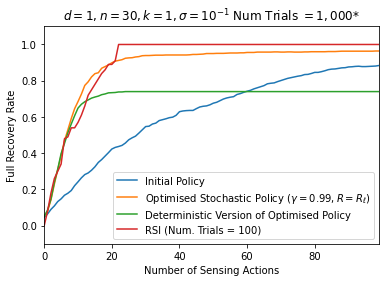

In [599]:
NUM_OBSERVATIONS = 100
NUM_TRIALS = 1000

sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low[:,0,:]).flatten(),ci='sd',label='Initial Policy',err_kws={'alpha':0})
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_short[:,1,:]).flatten(),ci='sd',label='Single Cell Random')
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low[:,2,:]).flatten(),ci='sd',label='Optimised Stochastic Policy $(\gamma=0.99,R=R_\ell)$',err_kws={'alpha':0})
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low[:,3,:]).flatten(),ci='sd',label='Deterministic Version of Optimised Policy',err_kws={'alpha':0})
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*100,y=np.asarray(recoveries_low[:,:]).flatten(),ci='sd',label='RSI',err_kws={'alpha':0})
sns.lineplot(x=list(range(100))*100,y=np.asarray(RSI[:,:].T).flatten(),ci='sd',label='RSI (Num. Trials = 100)',err_kws={'alpha':0})
sns.lineplot(x=list(range(100))*250,y=np.asarray(RSI_combined[:,:].T).flatten(),ci='sd',label='RSI (Num. Trials = 250)',err_kws={'alpha':0})
plt.xlabel('Number of Sensing Actions')
plt.ylabel('Full Recovery Rate')
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$ Num Trials $= 1,000$*')
plt.legend(loc='lower right')
plt.ylim([-0.1,1.1])
plt.xlim([0,99])
# plt.savefig('full_recovery_k1_low_RSI.pdf')

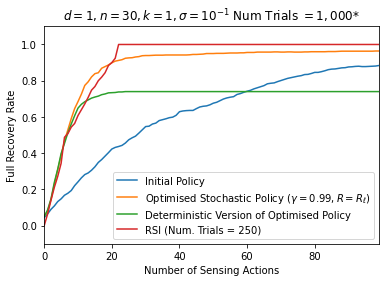

In [651]:
NUM_OBSERVATIONS = 100
NUM_TRIALS = 1000

sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low[:,0,:]).flatten(),ci='sd',label='Initial Policy',err_kws={'alpha':0})
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_short[:,1,:]).flatten(),ci='sd',label='Single Cell Random')
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low[:,2,:]).flatten(),ci='sd',label='Optimised Stochastic Policy $(\gamma=0.99,R=R_\ell)$',err_kws={'alpha':0})
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low[:,3,:]).flatten(),ci='sd',label='Deterministic Version of Optimised Policy',err_kws={'alpha':0})
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*100,y=np.asarray(recoveries_low[:,:]).flatten(),ci='sd',label='RSI',err_kws={'alpha':0})
# sns.lineplot(x=list(range(100))*100,y=np.asarray(RSI[:,:].T).flatten(),ci='sd',label='RSI (Num. Trials = 100)',err_kws={'alpha':0})
sns.lineplot(x=list(range(100))*250,y=np.asarray(RSI_combined[:,:].T).flatten(),ci='sd',label='RSI (Num. Trials = 250)',err_kws={'alpha':0})
plt.xlabel('Number of Sensing Actions')
plt.ylabel('Full Recovery Rate')
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$ Num Trials $= 1,000$*')
plt.legend(loc='lower right')
plt.ylim([-0.1,1.1])
plt.xlim([0,99])
plt.savefig('full_recovery_k1_low_RSI.pdf')

In [645]:
import pickle 

ramina2 = pickle.load(open('/Users/conor/Documents/PHD_RESEARCH/ACTIVE_SEARCH_AS_RL/arxiv_Code/1D_search/results/results.pkl', 'rb'))
ramina0 = pickle.load(open('/Users/conor/Documents/PHD_RESEARCH/ACTIVE_SEARCH_AS_RL/arxiv_Code/1D_search/results/results0.pkl', 'rb'))

RSI = ramina0[1][0,:,:,1]
RSI = np.concatenate((RSI,np.ones((70,100))))

RSI_2 = ramina[1][0,:,:,1]
RSI_2 = np.concatenate((RSI_2,np.ones((70,150))))

RSI_combined = np.hstack((RSI,RSI_2))

Text(0, 0.5, 'Full Recovery Rate')

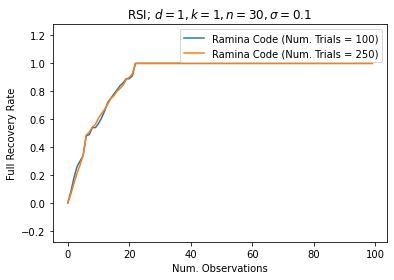

In [648]:
sns.lineplot(x=list(range(100))*100,y=np.asarray(RSI[:,:].T).flatten(),ci='sd',label='Ramina Code (Num. Trials = 100)',err_kws={'alpha':0})
sns.lineplot(x=list(range(100))*250,y=np.asarray(RSI_combined[:,:].T).flatten(),ci='sd',label='Ramina Code (Num. Trials = 250)',err_kws={'alpha':0})
plt.title('RSI; $d=1,k=1,n=30,\sigma=0.1$')
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*100,y=np.asarray(recoveries_low[:,:]).flatten(),ci='sd',label='My Code (Num. Trials = 100)',err_kws={'alpha':0})
plt.xlabel('Num. Observations')
plt.ylabel('Full Recovery Rate')
# plt.savefig('RSI.png', dpi=300,facecolor='w')

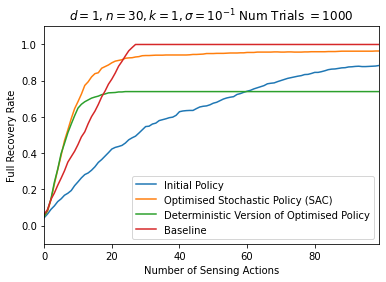

In [509]:
NUM_OBSERVATIONS = 100
NUM_TRIALS = 1000

sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low[:,0,:]).flatten(),ci='sd',label='Initial Policy',err_kws={'alpha':0})
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_short[:,1,:]).flatten(),ci='sd',label='Single Cell Random')
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low[:,2,:]).flatten(),ci='sd',label='Optimised Stochastic Policy (SAC)',err_kws={'alpha':0})
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low[:,3,:]).flatten(),ci='sd',label='Deterministic Version of Optimised Policy',err_kws={'alpha':0})
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recoveries_low_k1[:,:]).flatten(),ci='sd',label='Baseline',err_kws={'alpha':0})
plt.xlabel('Number of Sensing Actions')
plt.ylabel('Full Recovery Rate')
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$ Num Trials $= 1000$')
plt.legend(loc='lower right')
plt.ylim([-0.1,1.1])
plt.xlim([0,99])
plt.savefig('full_recovery_k1_low.pdf')

Conclusion: RL struggles to outperform herusitic analogue (but early in rollut outperforms). Two potential sources of the problem: 1) inappropriately low discount factor, 2) inappropriate reward function. Going to examine both of these next.

# Low-noise single target with larger discount factor [Complete]
 Load and plot RL training curves

In [445]:
data_low_k1_highdisc = pd.read_csv('../data/tabular-active-search-k1-low-higherdiscount/tabular_active_search_k1_low_higherdiscount_2020_11_13_17_15_22_0000--s-0/progress.csv')


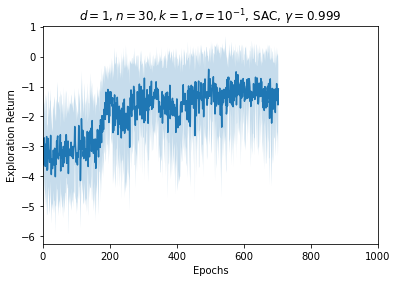

In [446]:
data = data_low_k1_highdisc
_ = plt.fill_between(data['Epoch'],data['exploration/Returns Mean'] - data['exploration/Returns Std'] , data['exploration/Returns Mean'] + data['exploration/Returns Std'],alpha=0.25)
_ = plt.plot(data['exploration/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$, SAC, $\gamma=0.999$')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Exploration Return')
_ = plt.xlim([0,1000])
# plt.savefig('RL_curve_k1_det_expl.pdf')

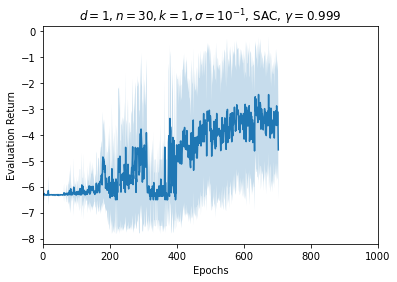

In [447]:
data = data_low_k1_highdisc
_ = plt.fill_between(data['Epoch'],data['evaluation/Returns Mean'] - data['evaluation/Returns Std'] , data['evaluation/Returns Mean'] + data['evaluation/Returns Std'],alpha=0.25)
_ = plt.plot(data['evaluation/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$, SAC, $\gamma=0.999$')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Evaluation Return')
_ = plt.xlim([0,1000])
# plt.savefig('RL_curve_k1_det_eval.pdf')

Load, generate and plot full-recovery results

In [420]:
entropy_results_low_higherdiscount = pickle.load(open('/Users/conor/Documents/PHD_RESEARCH/ACTIVE_SEARCH_AS_RL/rlkit/scripts/entropy_results_low_higherdiscount.p', "rb" ))
recovery_results_low_higherdiscount = pickle.load(open('/Users/conor/Documents/PHD_RESEARCH/ACTIVE_SEARCH_AS_RL/rlkit/scripts/recovery_results_low_higherdiscount.p', "rb" ))

(0.0, 99.0)

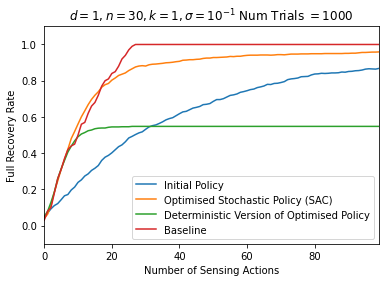

In [421]:
NUM_OBSERVATIONS = 100
NUM_TRIALS = 1000

sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low_higherdiscount[:,0,:]).flatten(),ci='sd',label='Initial Policy',err_kws={'alpha':0})
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_short[:,1,:]).flatten(),ci='sd',label='Single Cell Random')
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low_higherdiscount[:,2,:]).flatten(),ci='sd',label='Optimised Stochastic Policy (SAC)',err_kws={'alpha':0})
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low_higherdiscount[:,3,:]).flatten(),ci='sd',label='Deterministic Version of Optimised Policy',err_kws={'alpha':0})
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*100,y=np.asarray(recoveries_low[:,:]).flatten(),ci='sd',label='Baseline',err_kws={'alpha':0})
plt.xlabel('Number of Sensing Actions')
plt.ylabel('Full Recovery Rate')
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$ Num Trials $= 1000$')
plt.legend(loc='lower right')
plt.ylim([-0.1,1.1])
plt.xlim([0,99])
# plt.savefig('full_recovery_k1_low.pdf')

Conclusion: probably not discount issue. From trace, looks like problem might be misspecified reward. Trying this next.

# Low-noise single target with true reward function [Complete]
Load and plot RL training curves for

In [462]:
data_low_k1_true_rew = pd.read_csv('../data/tabular-active-search-k1-low-full-recover-reward/tabular_active_search_k1_low_full_recover_reward_2020_11_13_21_41_04_0000--s-0/progress.csv')

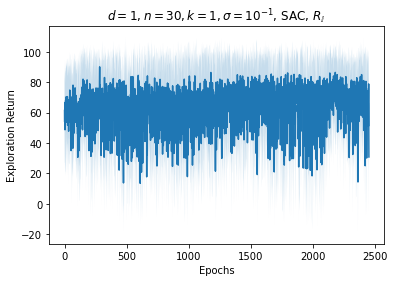

In [574]:
data = data_low_k1_true_rew
_ = plt.fill_between(data['Epoch'],data['exploration/Returns Mean'] - data['exploration/Returns Std'] , data['exploration/Returns Mean'] + data['exploration/Returns Std'],alpha=0.25)
_ = plt.plot(data['exploration/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$, SAC, $R_\mathbb{I}$')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Exploration Return')
# _ = plt.xlim([0,1000])
plt.savefig('RL_curve_k1_low_true_rew.pdf')

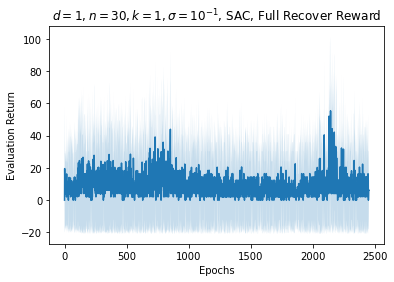

In [464]:
data = data_low_k1_true_rew
_ = plt.fill_between(data['Epoch'],data['evaluation/Returns Mean'] - data['evaluation/Returns Std'] , data['evaluation/Returns Mean'] + data['evaluation/Returns Std'],alpha=0.25)
_ = plt.plot(data['evaluation/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$, SAC, Full Recover Reward')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Evaluation Return')
# _ = plt.xlim([0,1000])
# plt.savefig('RL_curve_k1_det_eval.pdf')

Conclusion: True reward function too hard to learn. Loss landscape probably too flat. Idea: might be easier to learn a convex combo of true reward and easier reward. Trying that next.

# Low noise single target with convex combo true reward function [Ongoing]
Load and plot RL training curves 

In [652]:
data_low_k1_convex = pd.read_csv('../data/tabular-active-search-k1-low-convex/tabular_active_search_k1_low_convex_2020_11_15_21_04_36_0000--s-0/progress.csv')


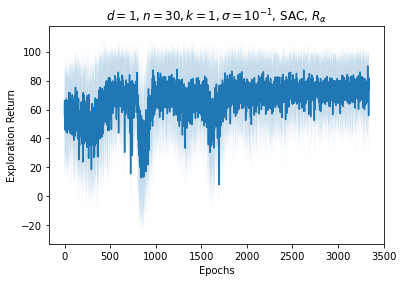

In [658]:
data = data_low_k1_convex
_ = plt.fill_between(data['Epoch'],data['exploration/Returns Mean'] - data['exploration/Returns Std'] , data['exploration/Returns Mean'] + data['exploration/Returns Std'],alpha=0.25)
_ = plt.plot(data['exploration/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$, SAC, $R_\alpha$')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Exploration Return')
# _ = plt.xlim([1000,1800])
plt.savefig('RL_curve_k1_combo.pdf')

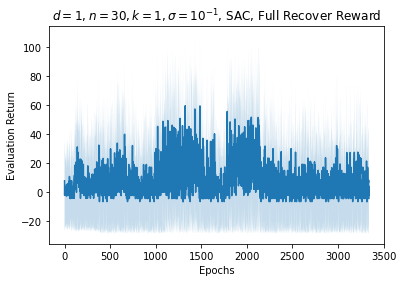

In [654]:
data = data_low_k1_convex
_ = plt.fill_between(data['Epoch'],data['evaluation/Returns Mean'] - data['evaluation/Returns Std'] , data['evaluation/Returns Mean'] + data['evaluation/Returns Std'],alpha=0.25)
_ = plt.plot(data['evaluation/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$, SAC, Full Recover Reward')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Evaluation Return')
# _ = plt.xlim([0,1000])
# plt.savefig('RL_curve_k1_det_eval.pdf')

Conclusion: Doesn't seem to show promise (similar behaviour for double target deterministic convex experiment). Trying with a reduced full recovery reward coefficient next.

In [655]:
entropy_results_low_k1_combo = pickle.load(open('/Users/conor/Documents/PHD_RESEARCH/ACTIVE_SEARCH_AS_RL/rlkit/scripts/entropy_results_low_k1_combo.p', "rb" ))
recovery_results_low_k1_combo = pickle.load(open('/Users/conor/Documents/PHD_RESEARCH/ACTIVE_SEARCH_AS_RL/rlkit/scripts/recovery_results_low_k1_combo.p', "rb" ))

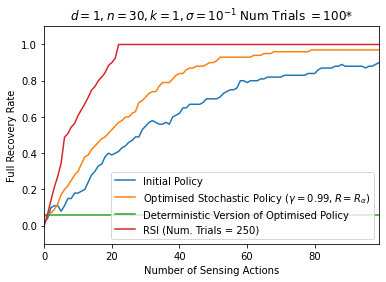

In [664]:
NUM_OBSERVATIONS = 100
NUM_TRIALS = 100

sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low_k1_combo[:,0,:]).flatten(),ci='sd',label='Initial Policy',err_kws={'alpha':0})
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_short[:,1,:]).flatten(),ci='sd',label='Single Cell Random')
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low_k1_combo[:,2,:]).flatten(),ci='sd',label=r'Optimised Stochastic Policy $(\gamma=0.99,R=R_{\alpha})$',err_kws={'alpha':0})
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low_k1_combo[:,3,:]).flatten(),ci='sd',label='Deterministic Version of Optimised Policy',err_kws={'alpha':0})
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*100,y=np.asarray(recoveries_low[:,:]).flatten(),ci='sd',label='Baseline',err_kws={'alpha':0})
sns.lineplot(x=list(range(100))*250,y=np.asarray(RSI_combined[:,:].T).flatten(),ci='sd',label='RSI (Num. Trials = 250)',err_kws={'alpha':0})
plt.xlabel('Number of Sensing Actions')
plt.ylabel('Full Recovery Rate')
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$ Num Trials $= 100$*')
plt.legend(loc='lower right')
plt.ylim([-0.1,1.1])
plt.xlim([0,99])
plt.savefig('full_recovery_k1_low_combo.pdf')

In [ ]:
NUM_OBSERVATIONS = 100
NUM_TRIALS = 1000

sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low[:,0,:]).flatten(),ci='sd',label='Initial Policy',err_kws={'alpha':0})
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_short[:,1,:]).flatten(),ci='sd',label='Single Cell Random')
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low[:,2,:]).flatten(),ci='sd',label='Optimised Stochastic Policy $(\gamma=0.99,R=R_\ell)$',err_kws={'alpha':0})
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low[:,3,:]).flatten(),ci='sd',label='Deterministic Version of Optimised Policy',err_kws={'alpha':0})
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*100,y=np.asarray(recoveries_low[:,:]).flatten(),ci='sd',label='RSI',err_kws={'alpha':0})
# sns.lineplot(x=list(range(100))*100,y=np.asarray(RSI[:,:].T).flatten(),ci='sd',label='RSI (Num. Trials = 100)',err_kws={'alpha':0})
sns.lineplot(x=list(range(100))*250,y=np.asarray(RSI_combined[:,:].T).flatten(),ci='sd',label='RSI (Num. Trials = 250)',err_kws={'alpha':0})
plt.xlabel('Number of Sensing Actions')
plt.ylabel('Full Recovery Rate')
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$ Num Trials $= 1,000$*')
plt.legend(loc='lower right')
plt.ylim([-0.1,1.1])
plt.xlim([0,99])
plt.savefig('full_recovery_k1_low_RSI.pdf')

# Low noise single target with convex combo true reward function, and reduced full recovery coefficient [Ongoing]
Load and plot RL training curves

In [619]:
data_low_k1_convex_low_full = pd.read_csv('../data/tabular-active-search-k1-low-if-full-harder/tabular_active_search_k1_low_if_full_harder_2020_11_16_10_53_58_0000--s-0/progress.csv')


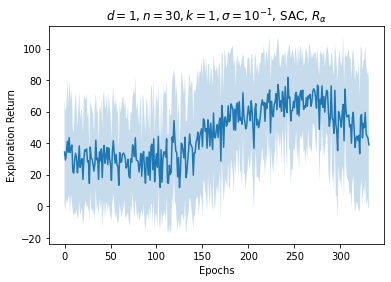

In [620]:
data = data_low_k1_convex_low_full
_ = plt.fill_between(data['Epoch'],data['exploration/Returns Mean'] - data['exploration/Returns Std'] , data['exploration/Returns Mean'] + data['exploration/Returns Std'],alpha=0.25)
_ = plt.plot(data['exploration/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$, SAC, $R_\alpha$')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Exploration Return')
# _ = plt.xlim([1000,1800])
# plt.savefig('RL_curve_k1_combo.pdf')

# Deterministic double target [Paused]
Load and plot RL training curves

In [622]:
data_det_k2 = pd.read_csv('../data/tabular-active-search-k2-det/tabular_active_search_k2_det_2020_11_13_13_11_30_0000--s-0/progress.csv')

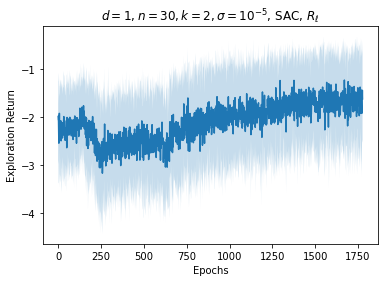

In [625]:
data = data_det_k2
_ = plt.fill_between(data['Epoch'],data['exploration/Returns Mean'] - data['exploration/Returns Std'] , data['exploration/Returns Mean'] + data['exploration/Returns Std'],alpha=0.25)
_ = plt.plot(data['exploration/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=2, \sigma = 10^{-5}$, SAC, $R_\ell$')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Exploration Return')
# _ = plt.xlim([0,1000])
plt.savefig('RL_curve_k2_det_expl.pdf')

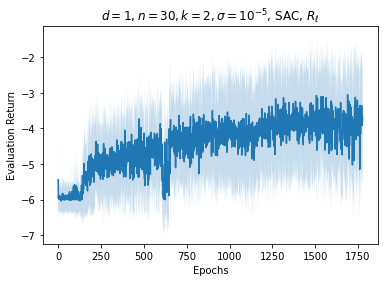

In [626]:
data = data_det_k2
_ = plt.fill_between(data['Epoch'],data['evaluation/Returns Mean'] - data['evaluation/Returns Std'] , data['evaluation/Returns Mean'] + data['evaluation/Returns Std'],alpha=0.25)
_ = plt.plot(data['evaluation/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=2, \sigma = 10^{-5}$, SAC, $R_\ell$')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Evaluation Return')
# _ = plt.xlim([0,1000])
plt.savefig('RL_curve_k2_det_eval.pdf')

Load, generate and plot full-recovery results

In [627]:
entropy_results_det_k2 = pickle.load(open('/Users/conor/Documents/PHD_RESEARCH/ACTIVE_SEARCH_AS_RL/rlkit/scripts/entropy_results_det_k2.p', "rb" ))
recovery_results_det_k2 = pickle.load(open('/Users/conor/Documents/PHD_RESEARCH/ACTIVE_SEARCH_AS_RL/rlkit/scripts/recovery_results_det_k2.p', "rb" ))

In [455]:
n= 30
T = 100
sparse_vecs = set()
NUM_TRIALS = 10
NUM_MONTE_CARLO_SAMPLES = 1
sigma=.00001

bel = Belief(n,sigma=sigma,k=2)

recoveries_k2_det = np.zeros((NUM_TRIALS,T))

sensing_actions = set()


for i in range(n):
    for j in range(n):    
        sparse_vec = np.zeros(n)
        sparse_vec[i] = 1
        sparse_vec[j] = 1    
        sparse_vecs.add(tuple(sparse_vec))

for i in range(n):
    for j in range(n):
        x = np.zeros(n)
        start = i
        length = min( max(j,1), n-i)
        interval = np.ones(length) / length
        x[start:start+length] = interval
        sensing_actions.add(tuple(x))

sparse_vecs = np.asarray(list(sparse_vecs))
sensing_actions = np.asarray(list(sensing_actions))

for trial in range(NUM_TRIALS):
    bel = Belief(n,sigma=sigma,k=2)    
    beta = bel.sample()
            
    for t in range(T):
        print(trial,t)
        best = np.inf
        for sensing_action in sensing_actions:
            av_entropy = 0
            for m in range(NUM_MONTE_CARLO_SAMPLES):
                beta_tilde = bel.sample()
                bel_tilde = copy.deepcopy(bel)
                y_tilde = sensing_action @ beta_tilde + (np.random.normal()*sigma)
                bel_tilde.filt(sensing_action,y_tilde)
                av_entropy += bel_tilde.entropy() / NUM_MONTE_CARLO_SAMPLES
                
            if av_entropy < best:
                best = av_entropy
                x = sensing_action

        y = x @ beta + (np.random.normal()*sigma)
        bel.filt(x,y)
        
        recovery = int(np.all(bel.sparse_vecs[np.argmax(bel.prior)] == beta))
        recoveries_k2_det[trial][t] = recovery

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
2 0
2 1
2 2
2 3
2 4


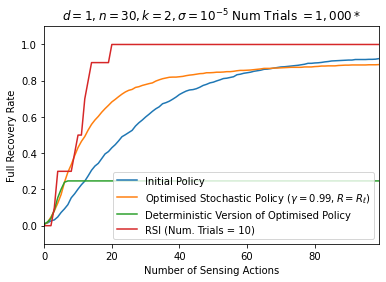

In [631]:
NUM_OBSERVATIONS = 100
NUM_TRIALS = 1000

sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_k2[:,0,:]).flatten(),ci='sd',label='Initial Policy',err_kws={'alpha':0})
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_k2[:,1,:]).flatten(),ci='sd',label='Single Cell Random')
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_k2[:,2,:]).flatten(),ci='sd',label='Optimised Stochastic Policy $(\gamma=0.99,R=R_\ell)$',err_kws={'alpha':0})
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_k2[:,3,:]).flatten(),ci='sd',label='Deterministic Version of Optimised Policy',err_kws={'alpha':0})
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*10,y=np.asarray(recoveries_k2_det[:,:]).flatten(),ci='sd',label='RSI (Num. Trials = 10)',err_kws={'alpha':0})
plt.xlabel('Number of Sensing Actions')
plt.ylabel('Full Recovery Rate')
_ = plt.title(r'$d=1,n=30,k=2, \sigma = 10^{-5}$ Num Trials $= 1,000*$')
plt.legend(loc='lower right')
plt.ylim([-0.1,1.1])
plt.xlim([0,99])
plt.savefig('full_recovery_k2_det.pdf')

Plot updated full recovery results

(0.0, 99.0)

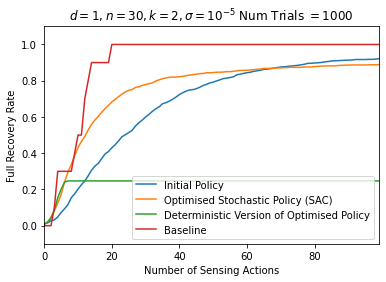

In [482]:
NUM_OBSERVATIONS = 100
NUM_TRIALS = 1000

sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_k2[:,0,:]).flatten(),ci='sd',label='Initial Policy',err_kws={'alpha':0})
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_k2[:,1,:]).flatten(),ci='sd',label='Single Cell Random')
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_k2[:,2,:]).flatten(),ci='sd',label='Optimised Stochastic Policy $(\gamma=0.99,R=R_\ell)$',err_kws={'alpha':0})
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_k2[:,3,:]).flatten(),ci='sd',label='Deterministic Version of Optimised Policy',err_kws={'alpha':0})
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*10,y=np.asarray(recoveries_k2_det[:,:]).flatten(),ci='sd',label='Baseline',err_kws={'alpha':0})
plt.xlabel('Number of Sensing Actions')
plt.ylabel('Full Recovery Rate')
_ = plt.title(r'$d=1,n=30,k=2, \sigma = 10^{-5}$ Num Trials $= 1,000*$')
plt.legend(loc='lower right')
plt.ylim([-0.1,1.1])
plt.xlim([0,99])
# plt.savefig('full_recovery_k2_det.pdf')

In [ ]:
NUM_OBSERVATIONS = 100
NUM_TRIALS = 1000

sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low[:,0,:]).flatten(),ci='sd',label='Initial Policy',err_kws={'alpha':0})
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_det_short[:,1,:]).flatten(),ci='sd',label='Single Cell Random')
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low[:,2,:]).flatten(),ci='sd',label='Optimised Stochastic Policy $(\gamma=0.99,R=R_\ell)$',err_kws={'alpha':0})
sns.lineplot(x=list(range(NUM_OBSERVATIONS))*NUM_TRIALS,y=np.asarray(recovery_results_low[:,3,:]).flatten(),ci='sd',label='Deterministic Version of Optimised Policy',err_kws={'alpha':0})
# sns.lineplot(x=list(range(NUM_OBSERVATIONS))*100,y=np.asarray(recoveries_low[:,:]).flatten(),ci='sd',label='RSI',err_kws={'alpha':0})
sns.lineplot(x=list(range(100))*100,y=np.asarray(RSI[:,:].T).flatten(),ci='sd',label='RSI (Num. Trials = 100)',err_kws={'alpha':0})
plt.xlabel('Number of Sensing Actions')
plt.ylabel('Full Recovery Rate')
_ = plt.title(r'$d=1,n=30,k=1, \sigma = 10^{-1}$ Num Trials $= 1,000$*')
plt.legend(loc='lower right')
plt.ylim([-0.1,1.1])
plt.xlim([0,99])
plt.savefig('full_recovery_k1_low_RSI.pdf')

"Conclusion": exacerbated issue as seen in low noise single target setting. Still running for longer as RL curves still haven't plateued.

# Load and plot RL training curves for deterministic double target case (higher discount, convex combo reward)
Complete

In [500]:
data_det_k2_convex = pd.read_csv('../data/tabular-active-search-k2-det-convex-higher-disc/tabular_active_search_k2_det_convex_higher_disc_2020_11_14_11_33_01_0000--s-0/progress.csv')

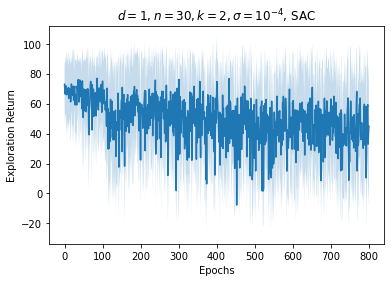

In [493]:
data = data_det_k2_convex
_ = plt.fill_between(data['Epoch'],data['exploration/Returns Mean'] - data['exploration/Returns Std'] , data['exploration/Returns Mean'] + data['exploration/Returns Std'],alpha=0.25)
_ = plt.plot(data['exploration/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=2, \sigma = 10^{-4}$, SAC')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Exploration Return')
# _ = plt.xlim([0,1000])
# plt.savefig('RL_curve_k1_det_expl.pdf')

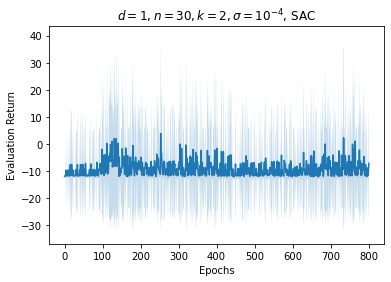

In [494]:
data = data_det_k2_convex
_ = plt.fill_between(data['Epoch'],data['evaluation/Returns Mean'] - data['evaluation/Returns Std'] , data['evaluation/Returns Mean'] + data['evaluation/Returns Std'],alpha=0.25)
_ = plt.plot(data['evaluation/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=2, \sigma = 10^{-4}$, SAC')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Evaluation Return')
# _ = plt.xlim([0,1000])
# plt.savefig('RL_curve_k1_det_eval.pdf')

Conclusion: convex combo too hard to learn too. Maybe the new term is interfering too much early in training? Seems unlikely... try making it smaller to see.

# Load and plot RL training curves for deterministic double target case (convex combo reward, with lower weight on the full-recovery term)
Ongoing

In [501]:
data_det_k2_convex_lower_full = pd.read_csv('../data/tabular-active-search-k2-det-convex-low-full/tabular_active_search_k2_det_convex_low_full_2020_11_15_19_32_21_0000--s-0/progress.csv')

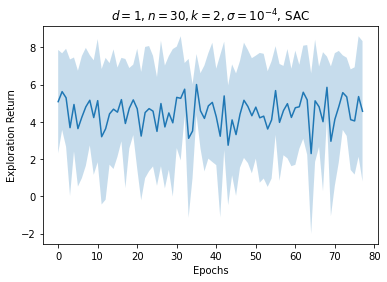

In [502]:
data = data_det_k2_convex_lower_full
_ = plt.fill_between(data['Epoch'],data['exploration/Returns Mean'] - data['exploration/Returns Std'] , data['exploration/Returns Mean'] + data['exploration/Returns Std'],alpha=0.25)
_ = plt.plot(data['exploration/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=2, \sigma = 10^{-4}$, SAC')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Exploration Return')
# _ = plt.xlim([0,1000])
# plt.savefig('RL_curve_k1_det_expl.pdf')

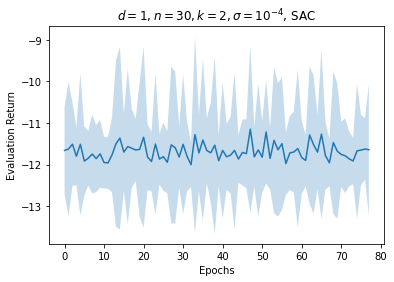

In [503]:
data = data_det_k2_convex_lower_full
_ = plt.fill_between(data['Epoch'],data['evaluation/Returns Mean'] - data['evaluation/Returns Std'] , data['evaluation/Returns Mean'] + data['evaluation/Returns Std'],alpha=0.25)
_ = plt.plot(data['evaluation/Returns Mean'])
_ = plt.title(r'$d=1,n=30,k=2, \sigma = 10^{-4}$, SAC')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Evaluation Return')
# _ = plt.xlim([0,1000])
# plt.savefig('RL_curve_k1_det_eval.pdf')